In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("/end/home/rh2310/morpho_repo/turing_codebase")
from turing.utils import *
import turing.pinns as tu
from turing.loss_functions import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

2022-12-20 17:54:18.996273: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-20 17:54:32.491175: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-12-20 17:54:32.833295: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:2d:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-12-20 17:54:32.833319: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-12-20 17:54:32.835174: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-12-20 17:54:32.837077: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10

# Load Koch Meinhardt dataset


In [2]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)

In [3]:
data.shape

(2, 100, 100, 769)

In [4]:
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/simulation.txt")
with open(data_path, 'r') as f:
    simulation = eval(f.read())


- $\frac{\partial u^*}{\partial t^*} =  (\partial_{x^* x^*} + \partial_{y^* y^*}) u^* + \rho^*_u \frac{(u^*)^2 v^*}{1 + \kappa_u (u^*)^2} - u^* + 1$
- $\frac{\partial v^*}{\partial t^*} =  D (\partial_{x^* x^*} + \partial_{y^* y^*}) v^*- \rho^*_v \frac{(u^*)^2 v^*}{1 + \kappa_u^* (u^*)^2} + 1$

- $  u = (\sigma_u/\mu_u) u^*$
- $  v = (\sigma_v/\mu_u) v^*$
- $  t = t^*/ \mu_u$
- $  x = \sqrt{\frac{D_u}{\mu_u}} x^*$
- $  y = \sqrt{\frac{D_u}{\mu_u}} y^*$
- $  D = \frac{D_v}{D_u}$
- $  \rho_u = (\frac{\mu_u^3}{\sigma_u \sigma_v}) \rho^*_u$
- $  \rho_v = (\frac{\mu_u^3}{\sigma_u^2}) \rho^*_v$
- $  \kappa_u = (\frac{\mu_u^2}{\sigma_u^2}) \kappa_u^*$

In [5]:
t_star = np.linspace(simulation.t_start, 
                     simulation.t_end, 
                     simulation.t_steps)
# Transfer t to t*
t_star *= simulation.parameters["mu_u"]
# Transfer u to u*
data[0, ...] *= simulation.parameters["mu_u"]/simulation.parameters["sigma_u"]  
# Transfer v to v*
data[1, ...] *= simulation.parameters["mu_u"]/simulation.parameters["sigma_v"]  

#t_star = t_star[-3:-1]
#data = data[..., -3:-1]
T = t_star.shape[0]    
    
# Make sure L is equal to L * sqrt(mu_u/D_u)
#L = simulation.L[0]
L = simulation.L[0]* np.sqrt(simulation.parameters["mu_u"]/simulation.Ds[0])
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

In [6]:
c_t = np.array([[(data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

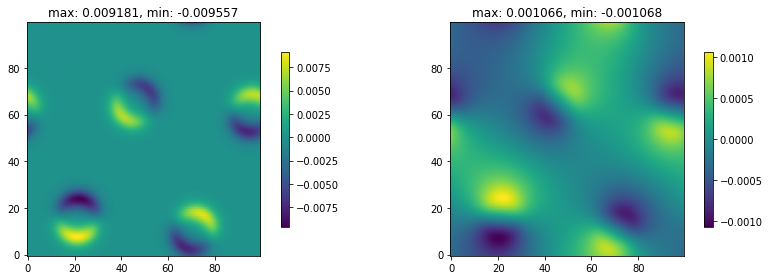

In [7]:
index = -1
_ = plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title(f"max: {np.max(c_t[0,:,:, index]):.6f}, min: {np.min(c_t[0,:,:, index]):.6f}")
plt.imshow(c_t[0,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.title(f"max: {np.max(c_t[1,:,:, index]):.6f}, min: {np.min(c_t[1,:,:, index]):.6f}")
plt.imshow(c_t[1,:,:, index].T, origin='lower')
plt.colorbar(shrink=.75)
plt.tight_layout()
plt.show()

In [8]:
data.shape

(2, 100, 100, 769)

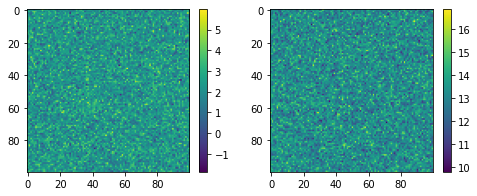

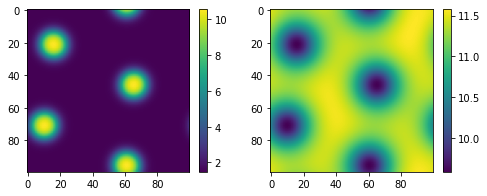

In [9]:
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, 0])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, 0])
plt.colorbar(shrink=.75)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(data[1,:,:, -1])
plt.colorbar(shrink=.75)
plt.show()

## Note: We use a prefactor to make the amplitude of u, v, u_xx, u_yy, u_t, v_xx, v_yy and v_t more or less in the same order of magnitude. And later, we do the inveres in solving the PDE. It is important for converging to the observed value.

In [10]:
# u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t
outputs_correction_fact = [1, 1, 1, 1, 100, 10, 10, 1000]
xx_factors = [1, 10]
yy_factors = [1, 10]
t_factors = [100, 1000]

dxdy = x_size*y_size/L**2
#c_xx =  np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
c_xx =  np.array([[xx_factors[c] * dxdy  * second_order_derivatives((x_size,y_size), data[c, ..., t])[0] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_xx = np.einsum("ctij -> cijt", c_xx)
#c_yy = np.array([[dxdy * simulation.Ds[c] * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
c_yy = np.array([[yy_factors[c] * dxdy * second_order_derivatives((x_size,y_size), data[c, ..., t])[1] 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
c_yy = np.einsum("ctij -> cijt", c_yy)

#c_t = np.array([[data[c, ..., t] -  data[c, ..., t-1] if t > 0 else data[c, ..., t] -  pre_data[c, ..., 0]
c_t = np.array([[t_factors[c] * (data[c, ..., t+1] -  data[c, ..., t])/(t_star[t+1] - t_star[t])
                    for t in range(data.shape[3]-1)]
                    for c in range(data.shape[0])
                   ])
c_t = np.einsum("ctij -> cijt", c_t)

In [11]:
dxdy = x_size*y_size/L**2
#diff_Y = np.array([[dxdy * simulation.Ds[c] *diffusion((x_size,y_size), data[c, ..., t]) 
diff_Y = np.array([[xx_factors[c] * dxdy * diffusion((x_size,y_size), data[c, ..., t]) 
                    for t in range(data.shape[3])]
                    for c in range(data.shape[0])
                   ])
diff_Y = np.einsum("ctij -> cijt", diff_Y)

In [12]:
T

769

In [13]:
c_t.shape

(2, 100, 100, 768)

In [14]:
t_star = t_star[-2:]
data = data[..., -2:]
c_xx = c_xx[..., -2:]
c_yy = c_yy[..., -2:]
c_t = c_t[..., -2:]
diff_Y = diff_Y[..., -2:]
T = t_star.shape[0]  

In [15]:
T

2

In [16]:
data.shape

(2, 100, 100, 2)

In [109]:
indices_all = np.arange(0, x_size*y_size*T, 1).reshape((T, x_size,y_size))
#indices_sub = indices_all[:, 30:60, 50:80]
#indices_sub = indices_all[:, 30:65, 50:85]
indices_sub = indices_all[:, 30:65:10, 50:85:10]
block_x = indices_sub.shape[1]
block_y = indices_sub.shape[2]
block_size = indices_sub.shape[1]*indices_sub.shape[2]


model_params = {'training_data_size': x_size*y_size*T,
                'pde_data_size': x_size*y_size*T,
                'boundary_data_size':((x_size + y_size)*T),
                'diffusion': diff_Y,
                'derivatives':[c_xx, c_yy, c_t], 
                'signal_to_noise':0.0,
                'shuffle':False,
                'idx_data':indices_sub.flatten()}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']

obs_inputs = dataset['obs_input']#np.vstack([dataset['obs_input'][first_s],
                        #dataset['obs_input'][second_s]])
obs_outputs = dataset['obs_output']#np.vstack([dataset['obs_output'][first_s],
#                          #dataset['obs_output'][second_s]])

# diff_outputs = dataset['diff_output']#np.vstack([dataset['diff_output'][first_s],
#                          #dataset['diff_output'][second_s]])
der_u_outputs = dataset["der_u"].T#np.vstack([dataset["der_u"][:,first_s].T,
                           #dataset["der_u"][:,second_s].T])
der_v_outputs = dataset["der_v"].T#np.vstack([dataset["der_v"][:,first_s].T,
                           #dataset["der_v"][:,second_s].T])
obs_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)
# obs_X = np.concatenate([obs_inputs, obs_outputs], axis=1)
pde_X = obs_inputs#dataset['pde']
# der_X = np.concatenate([obs_inputs, der_u_outputs, der_v_outputs], axis=1)
# obs_der_X = np.concatenate([obs_inputs, obs_outputs, der_u_outputs, der_v_outputs], axis=1)

# pbc_X = np.concatenate([dataset['boundary_LB'], dataset['boundary_RT']], axis=1)

#diffs = np.concatenate([dataset['diff_input'], dataset['diff_output']], axis=1)

#diffs_point = np.concatenate([obs_inputs, diff_outputs], axis=1)

In [18]:
obs_X.shape

(32, 11)

In [19]:
c_xx.shape

(2, 100, 100, 2)

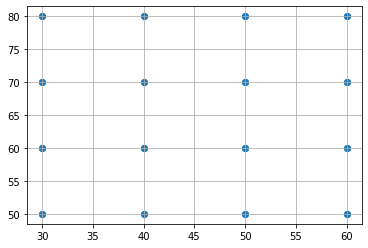

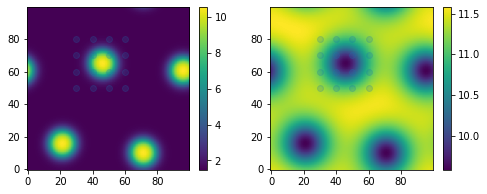

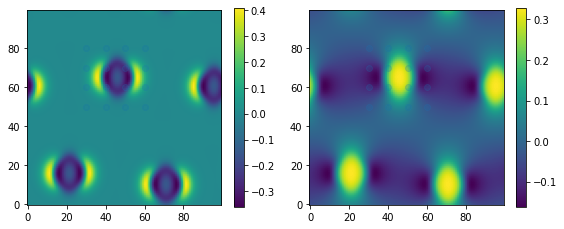

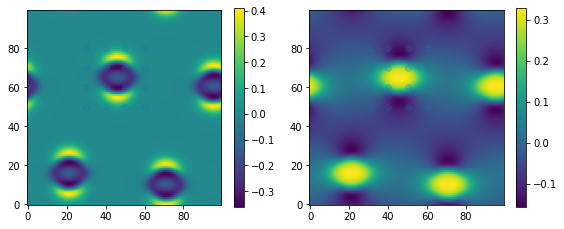

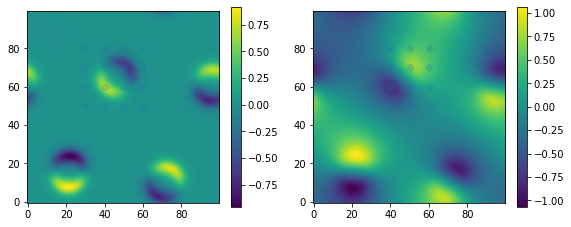

In [22]:
plt.scatter((x_size-1)*obs_X[:,0]/L, (x_size-1)*obs_X[:,1]/L)
plt.grid()
plt.show()

## Important Note:
##                Since in data the x is the first and y is the second indices,
##                x is cnahging in the outer arrays. So, we must transpose them on
##                ploting time
_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(data[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(data[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_xx[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_xx[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_yy[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_yy[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

_ = plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(c_t[0,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.subplot(122)
plt.imshow(c_t[1,:,:, -1].T, origin='lower')
plt.colorbar(shrink=.75)
plt.scatter((x_size-1)*obs_X[:,0]/L, (y_size-1)*obs_X[:,1]/L, alpha=.1)
plt.tight_layout()
plt.show()

In [23]:
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X, diffs)
#ds = TINN_Dataset(tf.float32, obs_X,  pde_X, pbc_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, pbc_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X)
#ds = TINN_Dataset(tf.float32, obs_X, pde_X, diffs_point)#, pbc_X)
#ds = TINN_Dataset(tf.float32, der_X, obs_X, pde_X)

# ds_der = TINN_Dataset(tf.float32, der_X)
# ds_der_1 = TINN_Dataset(tf.float32, obs_X, der_X_1)
# ds_test = TINN_Dataset(tf.float32, obs_test)
# ds_obs_der = TINN_Dataset(tf.float32, obs_der_X)
# ds = TINN_Dataset(tf.float32, obs_der_X, pde_X)


#ds_obs = TINN_Dataset(tf.float32, obs_X)
ds_obs = TINN_Dataset(tf.float32, obs_X, pde_X)

In [24]:
ds_obs.sizes

array([32, 32])

In [25]:
D = simulation.Ds[1]/simulation.Ds[0]
kappa_u = simulation.parameters["kappa_u"]*(simulation.parameters["sigma_u"]/simulation.parameters["mu_u"])**2
rho_u = simulation.parameters["rho_u"]*(simulation.parameters["sigma_u"]*simulation.parameters["sigma_v"]/simulation.parameters["mu_u"]**3)
rho_v = simulation.parameters["rho_v"]*(simulation.parameters["sigma_u"]**2/simulation.parameters["mu_u"]**3)


In [28]:
#layers = [3, 1024, 1024, 1024, 8]
#layers = [3, 512, 512, 512, 512, 2]
#layers = [3, 128, 128, 128, 128, 128, 2]
layers = [3, 32, 32, 32, 32, 8]

pinnKM = tu.NN(layers, lb, ub, dtype=tf.float32)
pde_resKM = Koch_Meinhard_Dimensionless_output_as_Der(
                    dtype = pinnKM.dtype,
                    D=PDE_Parameter("D", Parameter_Type.VARIABLE, 50.0,dtype=pinnKM.dtype),
                    #D=PDE_Parameter("D", Parameter_Type.CONSTANT, 
                    #                D, 
                    #                dtype=pinnKM.dtype),
                    kappa_u=PDE_Parameter("kappa_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype, zero_lb=True),
                    #kappa_u=PDE_Parameter("kappa_u", Parameter_Type.CONSTANT, 
                    #                      kappa_u,
                    #                      dtype=pinnKM.dtype),
                    rho_u=PDE_Parameter("rho_u", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
                    #rho_u=PDE_Parameter("rho_u", Parameter_Type.CONSTANT, 
                    #                    rho_u,
                    #                    dtype=pinnKM.dtype),                    
                    rho_v=PDE_Parameter("rho_v", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),                    
                    #rho_v=PDE_Parameter("rho_v", Parameter_Type.CONSTANT, 
                    #                    rho_v,
                    #                    dtype=pinnKM.dtype),
    outputs_correction_fact = [1, 1, 1, 1, 1/100, 1/10, 1/10, 1/1000],
    regularise=False
    )
# pde_resKM = Brusselator(
#                     D_u=PDE_Parameter("D_u", Parameter_Type.CONSTANT, simulation.Ds[0], dtype=pinnKM.dtype),
#                     D_v=PDE_Parameter("D_v", Parameter_Type.CONSTANT, simulation.Ds[1], dtype=pinnKM.dtype),                    
#                     A=PDE_Parameter("A", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype),
#                     B=PDE_Parameter("B", Parameter_Type.VARIABLE, 1.0,dtype=pinnKM.dtype), 
#                    regularise=True,
#     )
#obs_loss = Observation_Loss(regularise=True, input_dim=2)
obs_loss = Observation_Loss(layers=layers, 
                           residual_ret_names=("u", "v", "u_xx", "u_yy", "u_t", "v_xx", "v_yy", "v_t"))
#pbc_loss = Periodic_Boundary_Condition(regularise=True)
#diff_loss_point = Diffusion_point_Loss(
#                            Ds = simulation.Ds,
#                            #input_dim =2,
#                            dtype = pinnKM.dtype)
#der_loss = All_Derivatives_Loss(dtype = pinnKM.dtype,
                            #Ds = simulation.Ds,
#                           )
#obs_der_loss = Observation_And_Derivatives_Loss(dtype = pinnKM.dtype,
#                            Ds = simulation.Ds,
#                           )
# diff_loss = Diffusion_Loss(ns = simulation.n,
#                            Ls = simulation.L,
#                            Ds = simulation.Ds,
#                            dtype = pinnKM.dtype)

#nzp_loss = Non_zero_params("Koch_Meinhard", [pde_resKM.sigma_u.tf_var, pde_resKM.sigma_v.tf_var])
#obs_X, pde_X)
modelKM = tu.TINN(pinnKM, 
                  #losses= [obs_loss, pde_resKM, pbc_loss, diff_loss_point], 
                  #losses= [obs_loss, pde_resKM, diff_loss_point], 
                  #losses= [obs_der_loss],#, pde_resKM],
                  #losses= [der_loss, obs_loss, pde_resKM], 
                  losses= [obs_loss, pde_resKM],
                  norm = L2(),# + L_Inf(),
                  #no_input_losses=[nzp_loss],
                  optimizer=keras.optimizers.Adam(learning_rate=5e-4),
                  alpha = 0.9, 
                  loss_penalty_power = 3,
                  print_precision=".12f")

In [29]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)
modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 50000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0


2022-12-20 17:57:29.736418: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-20 17:57:31.977771: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 137.866958618164, total regularised loss: 137.866958618164
Observation_Loss -> 
(1)  u: 14.239055633545 (2)  v: 117.447738647461 (3)  u_xx: 0.023036748171 
(4)  u_yy: 0.019037483260 (5)  u_t: 0.054873630404 (6)  v_xx: 0.015807893127 
(7)  v_yy: 0.162768900394 (8)  v_t: 0.170775547624 
Loss_Koch_Meinhard -> 
(9)  res u: 1.023096442223 (10)  res v: 4.710773944855 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 49.99950 rho_u: 1.00039 rho_v: 0.99950 kappa_u: 1.00028 

Time taken: 3.69s

Start of epoch 1000
total loss: 6.749524116516, total regularised loss: 6.749524116516
Observation_Loss -> 
(1)  u: 5.762253761292 (2)  v: 0.270066618919 (3)  u_xx: 0.141794353724 
(4)  u_yy: 0.142355442047 (5)  u_t: 0.051030907780 (6)  v_xx: 0.057002410293 
(7)  v_yy: 0.056684106588 (8)  v_t: 0.13435059785


Start of epoch 8000
total loss: 1.568602919579, total regularised loss: 1.568602919579
Observation_Loss -> 
(1)  u: 0.300994634628 (2)  v: 0.028462056071 (3)  u_xx: 0.405483305454 
(4)  u_yy: 0.405493140221 (5)  u_t: 0.001542626764 (6)  v_xx: 0.009715103544 
(7)  v_yy: 0.009538872167 (8)  v_t: 0.000627776957 
Loss_Koch_Meinhard -> 
(9)  res u: 0.406132936478 (10)  res v: 0.000612488366 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 50.18031 rho_u: 0.24871 rho_v: 0.16353 kappa_u: 1.08947 

Time taken: 28.43s

Start of epoch 9000
total loss: 1.532835602760, total regularised loss: 1.532835602760
Observation_Loss -> 
(1)  u: 0.283388078213 (2)  v: 0.026851736009 (3)  u_xx: 0.400712072849 
(4)  u_yy: 0.400961905718 (5)  u_t: 0.001448716619 (6)  v_xx: 0.008742834441 
(7)  v_yy: 0.008334232494 (8)  v_t


Start of epoch 20000
total loss: 0.003059279174, total regularised loss: 0.003059279174
Observation_Loss -> 
(1)  u: 0.000010089943 (2)  v: 0.000001692119 (3)  u_xx: 0.000008296136 
(4)  u_yy: 0.000007655161 (5)  u_t: 0.000000442739 (6)  v_xx: 0.001478464692 
(7)  v_yy: 0.001478658523 (8)  v_t: 0.000000732809 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000007266880 (10)  res v: 0.000065980290 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 50.10545 rho_u: 0.01981 rho_v: 0.00947 kappa_u: 0.01047 

Time taken: 28.62s

Start of epoch 21000
total loss: 0.003032290377, total regularised loss: 0.003032290377
Observation_Loss -> 
(1)  u: 0.000008712588 (2)  v: 0.000001434280 (3)  u_xx: 0.000007963510 
(4)  u_yy: 0.000007547659 (5)  u_t: 0.000000289103 (6)  v_xx: 0.001471637748 
(7)  v_yy: 0.001470622839 (8)  v


Start of epoch 32000
total loss: 0.002779215807, total regularised loss: 0.002779215807
Observation_Loss -> 
(1)  u: 0.000007519059 (2)  v: 0.000001076822 (3)  u_xx: 0.000006431222 
(4)  u_yy: 0.000006357165 (5)  u_t: 0.000000147840 (6)  v_xx: 0.001352945575 
(7)  v_yy: 0.001352353371 (8)  v_t: 0.000000215688 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000007464512 (10)  res v: 0.000044704397 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 51.29502 rho_u: 0.01979 rho_v: 0.00960 kappa_u: 0.01045 

Time taken: 28.34s

Start of epoch 33000
total loss: 0.002765276935, total regularised loss: 0.002765276935
Observation_Loss -> 
(1)  u: 0.000005463834 (2)  v: 0.000001117713 (3)  u_xx: 0.000006033929 
(4)  u_yy: 0.000005985587 (5)  u_t: 0.000000275872 (6)  v_xx: 0.001350959647 
(7)  v_yy: 0.001347274752 (8)  v


Start of epoch 44000
total loss: 0.002527660690, total regularised loss: 0.002527660690
Observation_Loss -> 
(1)  u: 0.000007364961 (2)  v: 0.000000951986 (3)  u_xx: 0.000005869306 
(4)  u_yy: 0.000005882034 (5)  u_t: 0.000000111510 (6)  v_xx: 0.001228184556 
(7)  v_yy: 0.001228275243 (8)  v_t: 0.000000183379 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000005854703 (10)  res v: 0.000044983040 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 52.48414 rho_u: 0.01977 rho_v: 0.00973 kappa_u: 0.01042 

Time taken: 27.75s

Start of epoch 45000
total loss: 0.002507932717, total regularised loss: 0.002507932717
Observation_Loss -> 
(1)  u: 0.000007221980 (2)  v: 0.000000943902 (3)  u_xx: 0.000005796785 
(4)  u_yy: 0.000005802618 (5)  u_t: 0.000000110964 (6)  v_xx: 0.001219770638 
(7)  v_yy: 0.001219633967 (8)  v

In [49]:
modelKM.optimizer.lr.assign(5e-5)
results_KM3 = modelKM.train(epochs = 47000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.002416600706, total regularised loss: 0.002416600706
Observation_Loss -> 
(1)  u: 0.000005509888 (2)  v: 0.000000927614 (3)  u_xx: 0.000005259416 
(4)  u_yy: 0.000005246209 (5)  u_t: 0.000000159773 (6)  v_xx: 0.001180974534 
(7)  v_yy: 0.001178808743 (8)  v_t: 0.000000254967 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000007779287 (10)  res v: 0.000031680458 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 53.07855 rho_u: 0.01977 rho_v: 0.00979 kappa_u: 0.01041 

Time taken: 0.06s

Start of epoch 1000
total loss: 0.002401570091, total regularised loss: 0.002401570091
Observation_Loss -> 
(1)  u: 0.000006889334 (2)  v: 0.000000896125 (3)  u_xx: 0.000005514127 
(4)  u_yy: 0.000005526121 (5)  u_t: 0.000000102673 (6)  v_xx: 0.001167752198 
(7)  v_yy: 0.001167749520 (8)  v_t: 0.


Start of epoch 12000
total loss: 0.002299528802, total regularised loss: 0.002299528802
Observation_Loss -> 
(1)  u: 0.000006556588 (2)  v: 0.000000851586 (3)  u_xx: 0.000005240176 
(4)  u_yy: 0.000005249149 (5)  u_t: 0.000000095992 (6)  v_xx: 0.001118605956 
(7)  v_yy: 0.001118608518 (8)  v_t: 0.000000162314 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000005254687 (10)  res v: 0.000038903883 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 53.67364 rho_u: 0.01976 rho_v: 0.00986 kappa_u: 0.01040 

Time taken: 27.92s

Start of epoch 13000
total loss: 0.002290450968, total regularised loss: 0.002290450968
Observation_Loss -> 
(1)  u: 0.000006687161 (2)  v: 0.000000848077 (3)  u_xx: 0.000005228537 
(4)  u_yy: 0.000005234616 (5)  u_t: 0.000000092205 (6)  v_xx: 0.001114034210 
(7)  v_yy: 0.001114150858 (8)  v


Start of epoch 24000
total loss: 0.002192928223, total regularised loss: 0.002192928223
Observation_Loss -> 
(1)  u: 0.000006197634 (2)  v: 0.000000803211 (3)  u_xx: 0.000004946946 
(4)  u_yy: 0.000004953058 (5)  u_t: 0.000000082163 (6)  v_xx: 0.001067549689 
(7)  v_yy: 0.001067515928 (8)  v_t: 0.000000155056 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000004969258 (10)  res v: 0.000035755224 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 54.26873 rho_u: 0.01975 rho_v: 0.00992 kappa_u: 0.01038 

Time taken: 25.99s

Start of epoch 25000
total loss: 0.002184257144, total regularised loss: 0.002184257144
Observation_Loss -> 
(1)  u: 0.000006103064 (2)  v: 0.000000799998 (3)  u_xx: 0.000004920685 
(4)  u_yy: 0.000004928481 (5)  u_t: 0.000000082358 (6)  v_xx: 0.001063362346 
(7)  v_yy: 0.001063285046 (8)  v


Start of epoch 36000
total loss: 0.002091036178, total regularised loss: 0.002091036178
Observation_Loss -> 
(1)  u: 0.000005829677 (2)  v: 0.000000760422 (3)  u_xx: 0.000004682016 
(4)  u_yy: 0.000004690703 (5)  u_t: 0.000000074167 (6)  v_xx: 0.001018208684 
(7)  v_yy: 0.001018187730 (8)  v_t: 0.000000146586 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000004698254 (10)  res v: 0.000033757809 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 54.86383 rho_u: 0.01974 rho_v: 0.00999 kappa_u: 0.01037 

Time taken: 27.59s

Start of epoch 37000
total loss: 0.002082749736, total regularised loss: 0.002082749736
Observation_Loss -> 
(1)  u: 0.000005822157 (2)  v: 0.000000757157 (3)  u_xx: 0.000004663409 
(4)  u_yy: 0.000004671924 (5)  u_t: 0.000000074491 (6)  v_xx: 0.001014136244 
(7)  v_yy: 0.001014120644 (8)  v

In [ ]:
results_KM4 = modelKM.train(epochs = 25000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)

In [261]:
results_KM5 = modelKM.train(epochs = 75000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.001803001272, total regularised loss: 0.001803001272
Observation_Loss -> 
(1)  u: 0.000004901182 (2)  v: 0.000000641461 (3)  u_xx: 0.000003942708 
(4)  u_yy: 0.000003950622 (5)  u_t: 0.000000060204 (6)  v_xx: 0.000878984225 
(7)  v_yy: 0.000878966413 (8)  v_t: 0.000000118056 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003953876 (10)  res v: 0.000027482616 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 56.70708 rho_u: 0.01972 rho_v: 0.01019 kappa_u: 0.01034 

Time taken: 0.05s

Start of epoch 1000
total loss: 0.001795790275, total regularised loss: 0.001795790275
Observation_Loss -> 
(1)  u: 0.000004972748 (2)  v: 0.000000639218 (3)  u_xx: 0.000003926885 
(4)  u_yy: 0.000003932617 (5)  u_t: 0.000000059508 (6)  v_xx: 0.000875532161 
(7)  v_yy: 0.000875577505 (8)  v_t: 0.


Start of epoch 12000
total loss: 0.001718204236, total regularised loss: 0.001718204236
Observation_Loss -> 
(1)  u: 0.000004648654 (2)  v: 0.000000607864 (3)  u_xx: 0.000003728762 
(4)  u_yy: 0.000003735798 (5)  u_t: 0.000000057566 (6)  v_xx: 0.000838007836 
(7)  v_yy: 0.000837989617 (8)  v_t: 0.000000109346 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003737408 (10)  res v: 0.000025581425 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 57.30217 rho_u: 0.01972 rho_v: 0.01026 kappa_u: 0.01033 

Time taken: 27.33s

Start of epoch 13000
total loss: 0.001711304649, total regularised loss: 0.001711304649
Observation_Loss -> 
(1)  u: 0.000004622848 (2)  v: 0.000000604410 (3)  u_xx: 0.000003710947 
(4)  u_yy: 0.000003717391 (5)  u_t: 0.000000056018 (6)  v_xx: 0.000834708510 
(7)  v_yy: 0.000834699546 (8)  v


Start of epoch 24000
total loss: 0.001637094538, total regularised loss: 0.001637094538
Observation_Loss -> 
(1)  u: 0.000004408536 (2)  v: 0.000000574669 (3)  u_xx: 0.000003527440 
(4)  u_yy: 0.000003533157 (5)  u_t: 0.000000052921 (6)  v_xx: 0.000798784953 
(7)  v_yy: 0.000798787223 (8)  v_t: 0.000000103759 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003530329 (10)  res v: 0.000023791621 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 57.89724 rho_u: 0.01971 rho_v: 0.01032 kappa_u: 0.01032 

Time taken: 28.12s

Start of epoch 25000
total loss: 0.001630497980, total regularised loss: 0.001630497980
Observation_Loss -> 
(1)  u: 0.000004388243 (2)  v: 0.000000572176 (3)  u_xx: 0.000003511664 
(4)  u_yy: 0.000003517706 (5)  u_t: 0.000000051784 (6)  v_xx: 0.000795543136 
(7)  v_yy: 0.000795542321 (8)  v


Start of epoch 36000
total loss: 0.001559563912, total regularised loss: 0.001559563912
Observation_Loss -> 
(1)  u: 0.000004243900 (2)  v: 0.000000546650 (3)  u_xx: 0.000003334679 
(4)  u_yy: 0.000003333985 (5)  u_t: 0.000000050604 (6)  v_xx: 0.000761685485 
(7)  v_yy: 0.000761599105 (8)  v_t: 0.000000097073 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003343311 (10)  res v: 0.000021329062 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 58.49231 rho_u: 0.01971 rho_v: 0.01039 kappa_u: 0.01032 

Time taken: 27.21s

Start of epoch 37000
total loss: 0.001553196460, total regularised loss: 0.001553196460
Observation_Loss -> 
(1)  u: 0.000004137571 (2)  v: 0.000000541445 (3)  u_xx: 0.000003319939 
(4)  u_yy: 0.000003325321 (5)  u_t: 0.000000048814 (6)  v_xx: 0.000758117414 
(7)  v_yy: 0.000758106646 (8)  v


Start of epoch 48000
total loss: 0.001485275803, total regularised loss: 0.001485275803
Observation_Loss -> 
(1)  u: 0.000003940869 (2)  v: 0.000000515321 (3)  u_xx: 0.000003155219 
(4)  u_yy: 0.000003160058 (5)  u_t: 0.000000047659 (6)  v_xx: 0.000725199177 
(7)  v_yy: 0.000725191436 (8)  v_t: 0.000000090363 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003156731 (10)  res v: 0.000020818985 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 59.08738 rho_u: 0.01970 rho_v: 0.01045 kappa_u: 0.01031 

Time taken: 28.88s

Start of epoch 49000
total loss: 0.001479633152, total regularised loss: 0.001479633152
Observation_Loss -> 
(1)  u: 0.000004279595 (2)  v: 0.000000519194 (3)  u_xx: 0.000003211236 
(4)  u_yy: 0.000003221708 (5)  u_t: 0.000000049864 (6)  v_xx: 0.000720528886 
(7)  v_yy: 0.000720945653 (8)  v


Start of epoch 60000
total loss: 0.001414258382, total regularised loss: 0.001414258382
Observation_Loss -> 
(1)  u: 0.000003734408 (2)  v: 0.000000487915 (3)  u_xx: 0.000002984877 
(4)  u_yy: 0.000002988619 (5)  u_t: 0.000000045050 (6)  v_xx: 0.000690749963 
(7)  v_yy: 0.000690744724 (8)  v_t: 0.000000084867 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000002981603 (10)  res v: 0.000019456413 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 59.68241 rho_u: 0.01969 rho_v: 0.01052 kappa_u: 0.01030 

Time taken: 27.51s

Start of epoch 61000
total loss: 0.001408481505, total regularised loss: 0.001408481505
Observation_Loss -> 
(1)  u: 0.000003715396 (2)  v: 0.000000485386 (3)  u_xx: 0.000002970963 
(4)  u_yy: 0.000002974998 (5)  u_t: 0.000000044828 (6)  v_xx: 0.000687952270 
(7)  v_yy: 0.000687948894 (8)  v


Start of epoch 72000
total loss: 0.001346308156, total regularised loss: 0.001346308156
Observation_Loss -> 
(1)  u: 0.000003527056 (2)  v: 0.000000461370 (3)  u_xx: 0.000002821593 
(4)  u_yy: 0.000002824760 (5)  u_t: 0.000000043012 (6)  v_xx: 0.000657811877 
(7)  v_yy: 0.000657804077 (8)  v_t: 0.000000079148 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000002821792 (10)  res v: 0.000018113513 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 60.27742 rho_u: 0.01969 rho_v: 0.01058 kappa_u: 0.01029 

Time taken: 30.28s

Start of epoch 73000
total loss: 0.001341351424, total regularised loss: 0.001341351424
Observation_Loss -> 
(1)  u: 0.000003020210 (2)  v: 0.000000460719 (3)  u_xx: 0.000002738156 
(4)  u_yy: 0.000002739509 (5)  u_t: 0.000000052810 (6)  v_xx: 0.000657154247 
(7)  v_yy: 0.000656544114 (8)  v

In [288]:
results_KM6 = modelKM.train(epochs = 150000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=10000,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.001330134692, total regularised loss: 0.001330134692
Observation_Loss -> 
(1)  u: 0.000003842699 (2)  v: 0.000000460648 (3)  u_xx: 0.000002847122 
(4)  u_yy: 0.000002853286 (5)  u_t: 0.000000046348 (6)  v_xx: 0.000648126530 
(7)  v_yy: 0.000648637360 (8)  v_t: 0.000000086099 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000002742796 (10)  res v: 0.000020491803 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 60.42623 rho_u: 0.01969 rho_v: 0.01060 kappa_u: 0.01029 

Time taken: 0.07s

Start of epoch 10000
total loss: 0.001275993534, total regularised loss: 0.001275993534
Observation_Loss -> 
(1)  u: 0.000003319763 (2)  v: 0.000000434634 (3)  u_xx: 0.000002656919 
(4)  u_yy: 0.000002660024 (5)  u_t: 0.000000041000 (6)  v_xx: 0.000623631349 
(7)  v_yy: 0.000623632746 (8)  v_t: 0


Start of epoch 120000
total loss: 0.000810097554, total regularised loss: 0.000810097554
Observation_Loss -> 
(1)  u: 0.000001977975 (2)  v: 0.000000266000 (3)  u_xx: 0.000001607331 
(4)  u_yy: 0.000001607346 (5)  u_t: 0.000000029777 (6)  v_xx: 0.000396790332 
(7)  v_yy: 0.000396798045 (8)  v_t: 0.000000044964 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000001599293 (10)  res v: 0.000009376516 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 66.20605 rho_u: 0.01964 rho_v: 0.01124 kappa_u: 0.01022 

Time taken: 282.44s

Start of epoch 130000
total loss: 0.000777502835, total regularised loss: 0.000777502835
Observation_Loss -> 
(1)  u: 0.000001906478 (2)  v: 0.000000254745 (3)  u_xx: 0.000001531569 
(4)  u_yy: 0.000001530210 (5)  u_t: 0.000000029276 (6)  v_xx: 0.000381035119 
(7)  v_yy: 0.000381036371 (8)

In [309]:
results_KM7 = modelKM.train(epochs = 750000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=100000,
                          stop_threshold = 1e-5,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.000715602655, total regularised loss: 0.000715602655
Observation_Loss -> 
(1)  u: 0.000001741756 (2)  v: 0.000000233870 (3)  u_xx: 0.000001398637 
(4)  u_yy: 0.000001396960 (5)  u_t: 0.000000028542 (6)  v_xx: 0.000350829330 
(7)  v_yy: 0.000350827351 (8)  v_t: 0.000000040692 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000001389913 (10)  res v: 0.000007715576 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 67.58562 rho_u: 0.01963 rho_v: 0.01139 kappa_u: 0.01020 

Time taken: 0.40s

Start of epoch 100000
total loss: 0.000463218195, total regularised loss: 0.000463218195
Observation_Loss -> 
(1)  u: 0.000001093066 (2)  v: 0.000000150130 (3)  u_xx: 0.000000875218 
(4)  u_yy: 0.000000872319 (5)  u_t: 0.000000025006 (6)  v_xx: 0.000227454730 
(7)  v_yy: 0.000227462704 (8)  v_t: 

In [326]:
results_KM8 = modelKM.train(epochs = 250000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=50000,
                          stop_threshold = 1e-6,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.000061594403, total regularised loss: 0.000061594401
Observation_Loss -> 
(1)  u: 0.000000381963 (2)  v: 0.000000090547 (3)  u_xx: 0.000000102839 
(4)  u_yy: 0.000000094581 (5)  u_t: 0.000000109809 (6)  v_xx: 0.000024035888 
(7)  v_yy: 0.000023936402 (8)  v_t: 0.000000105861 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000003822672 (10)  res v: 0.000008913845 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 92.06558 rho_u: 0.01952 rho_v: 0.01411 kappa_u: 0.01004 

Time taken: 0.05s

Start of epoch 50000
total loss: 0.000019349949, total regularised loss: 0.000019349949
Observation_Loss -> 
(1)  u: 0.000000041736 (2)  v: 0.000000011389 (3)  u_xx: 0.000000043502 
(4)  u_yy: 0.000000040847 (5)  u_t: 0.000000013487 (6)  v_xx: 0.000009518879 
(7)  v_yy: 0.000009520132 (8)  v_t: 0

In [344]:
results_KM9 = modelKM.train(epochs = 1000000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=100000,
                          stop_threshold = 1e-6,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=False,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.000010539343, total regularised loss: 0.000010539343
Observation_Loss -> 
(1)  u: 0.000000023022 (2)  v: 0.000000008064 (3)  u_xx: 0.000000027868 
(4)  u_yy: 0.000000025508 (5)  u_t: 0.000000012143 (6)  v_xx: 0.000005175806 
(7)  v_yy: 0.000005176572 (8)  v_t: 0.000000012562 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000000018837 (10)  res v: 0.000000058962 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
D: 94.53265 rho_u: 0.01951 rho_v: 0.01439 kappa_u: 0.01002 

Time taken: 0.06s

Start of epoch 100000
total loss: 0.000007725507, total regularised loss: 0.000007725507
Observation_Loss -> 
(1)  u: 0.000000017257 (2)  v: 0.000000007029 (3)  u_xx: 0.000000022824 
(4)  u_yy: 0.000000020458 (5)  u_t: 0.000000011823 (6)  v_xx: 0.000003789027 
(7)  v_yy: 0.000003789253 (8)  v_t: 

In [345]:
print(D, rho_u, rho_v, kappa_u)
print(pde_resKM.trainables_str())

100.0 0.019500000000000003 0.015000000000000003 0.010000000000000002
D: 97.75625 rho_u: 0.01951 rho_v: 0.01475 kappa_u: 0.01001 



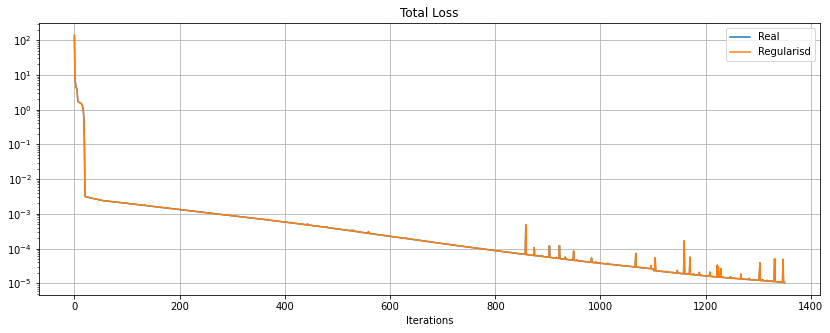

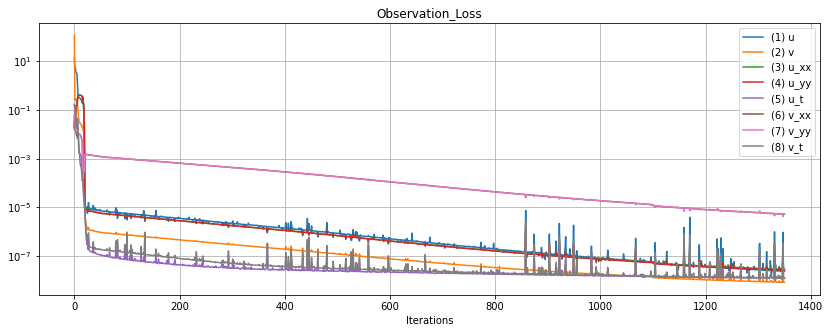

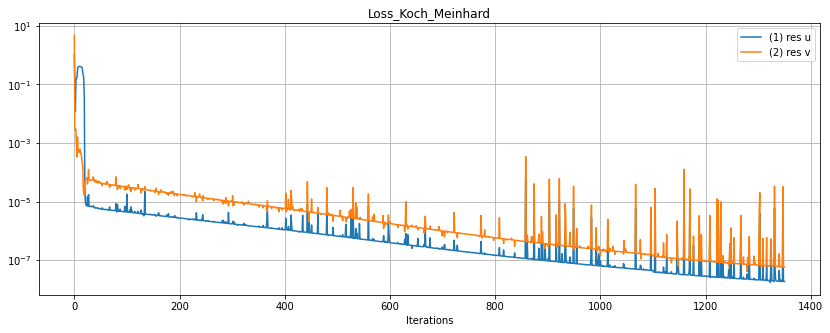

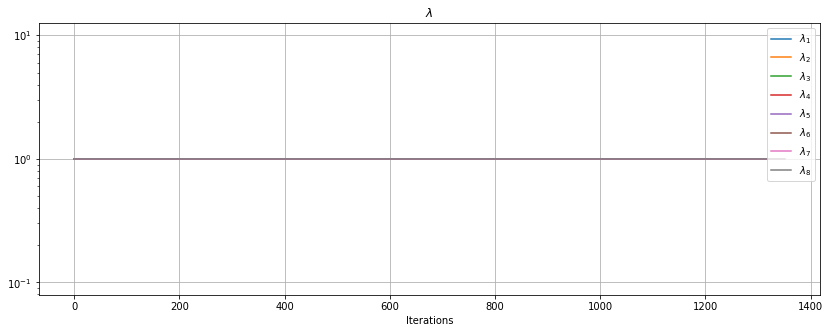

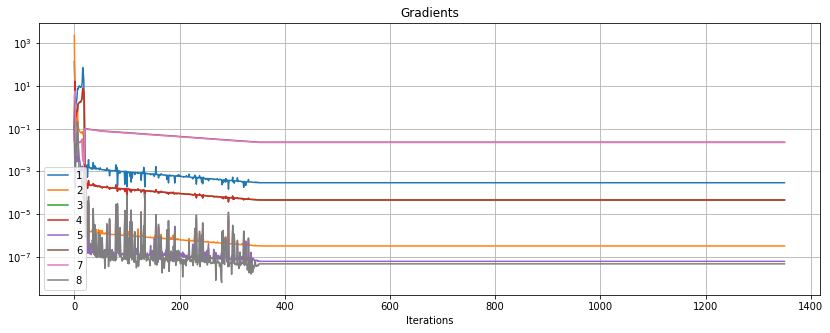

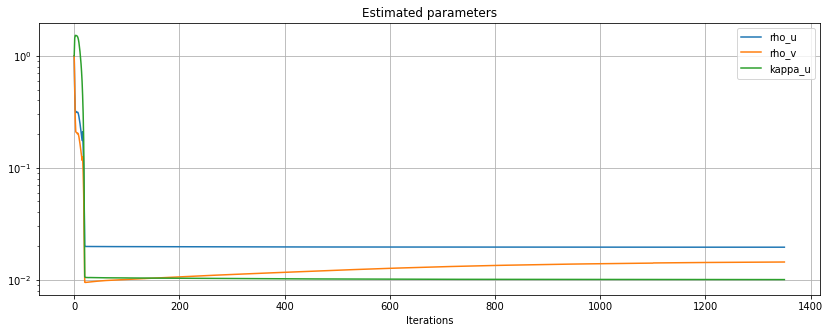

In [328]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3, results_KM4
                       , results_KM5, results_KM6, results_KM7, results_KM8), 
           modelKM, start=0,skip=1000, param_names=["rho_u", "rho_v", "kappa_u"])#pde_resKM.parameter_names())

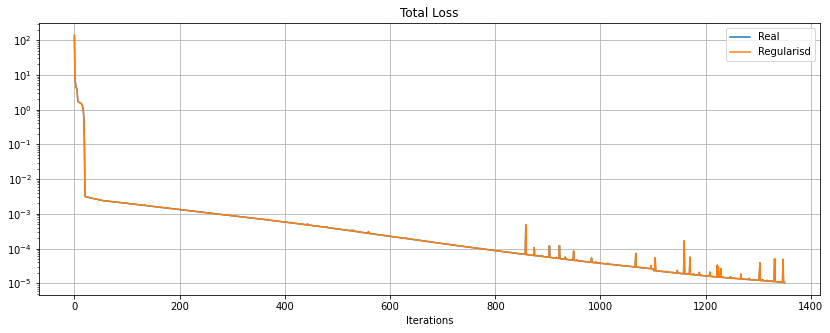

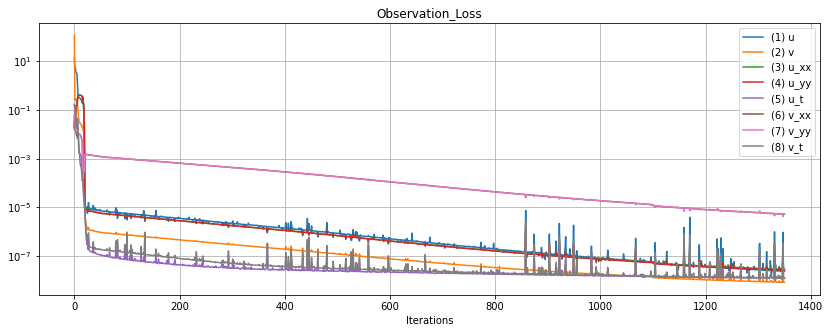

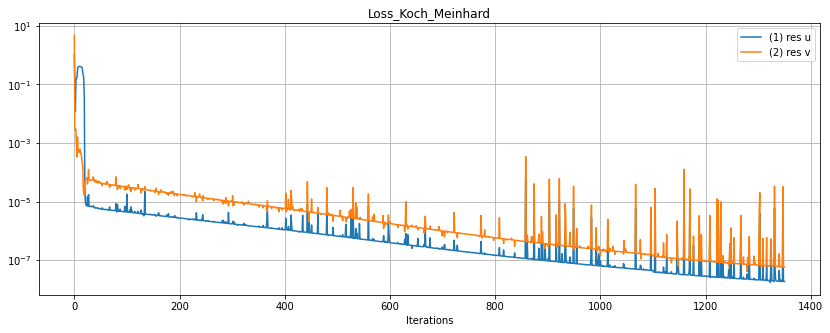

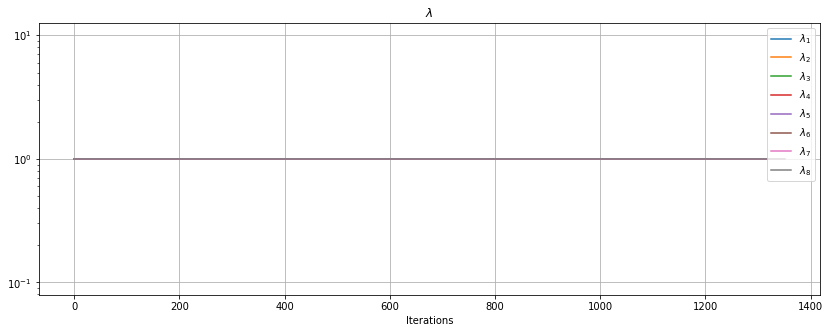

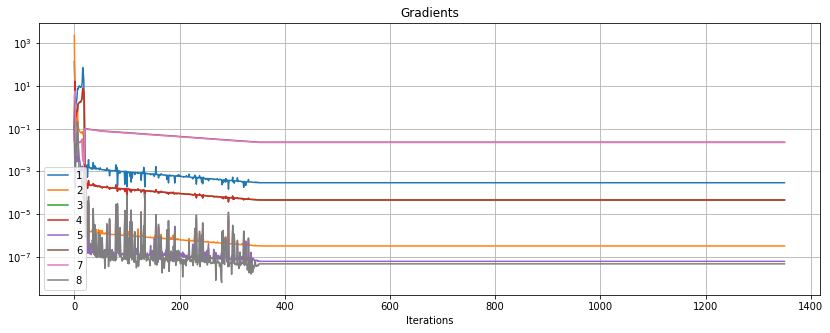

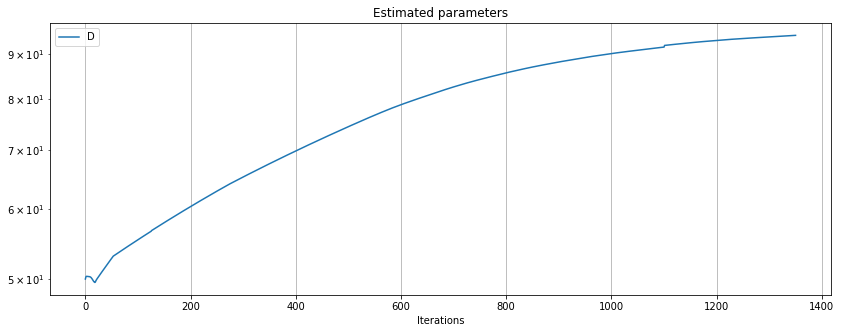

In [329]:
plot_result(merge_dict(results_KM, results_KM2, results_KM3, results_KM4
                       , results_KM5, results_KM6, results_KM7, results_KM8), 
           modelKM, start=0,skip=1000, param_names=["D"])#pde_resKM.parameter_names())

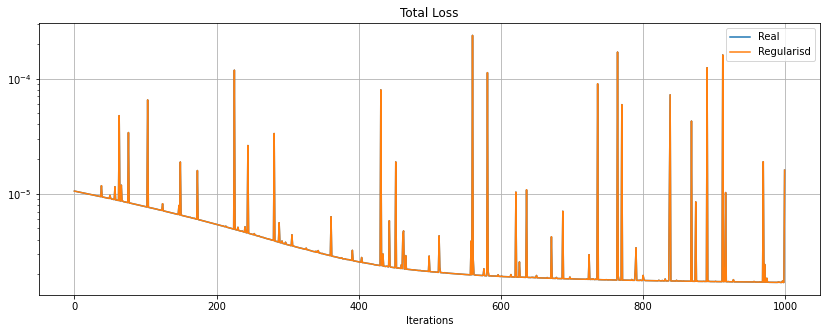

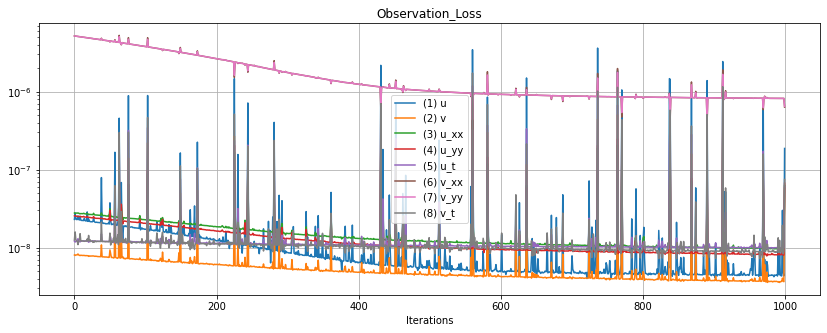

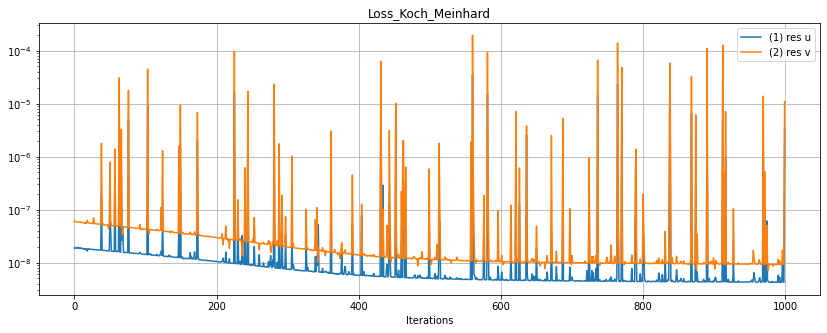

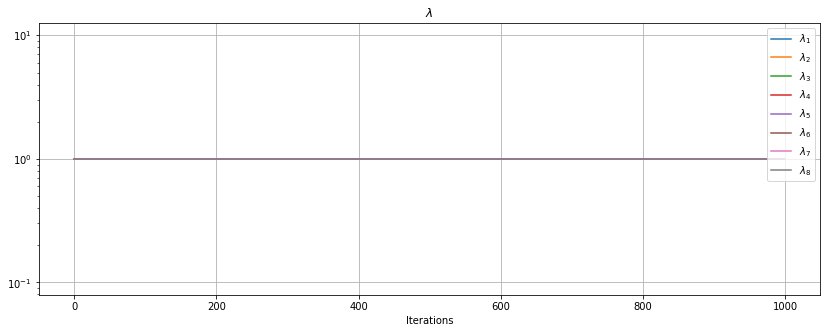

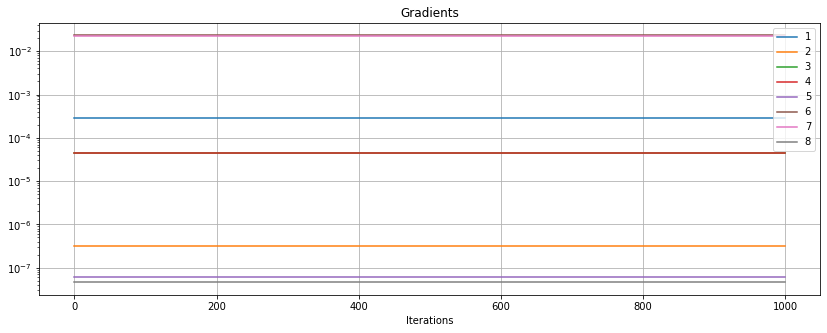

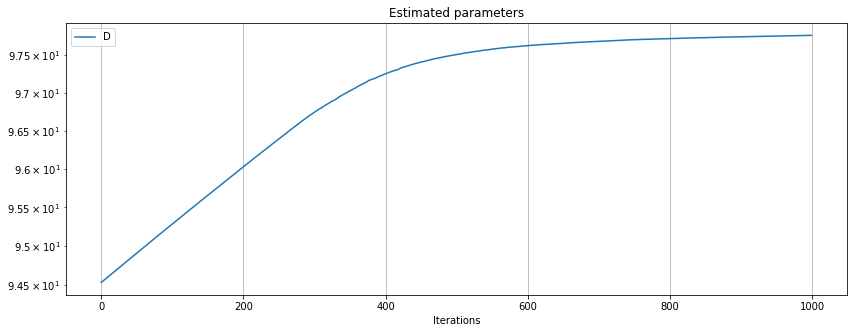

In [347]:
plot_result(merge_dict(results_KM9), 
           modelKM, start=0,skip=1000, param_names=["D"])

In [308]:
modelKM.save(".", "patch_points_parameter_estimation_derivatives_outputs_100000")

In [41]:
modelKM.optimizer.lr.assign(2e-4)
results_KM3 = modelKM.train(epochs = 50000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0
total loss: 0.059742257465, total regularised loss: 0.108918935061
Observation_Loss -> 
(1)  u: 0.000590749503 (2)  v: 0.000206446867 (3)  u_xx: 0.000476306869 
(4)  u_yy: 0.000465895554 (5)  u_t: 0.000029170411 (6)  v_xx: 0.001419079912 
(7)  v_yy: 0.001410461067 (8)  v_t: 0.000087196966 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000188909147 (10)  res v: 0.001100009469 
(1) lambdas : 0.391665607691 (2) lambdas : 0.090468451381 (3) lambdas : 0.290310949087 
(4) lambdas : 0.291347533464 (5) lambdas : 0.524001121521 (6) lambdas : 3.204200267792 
(7) lambdas : 3.201838731766 (8) lambdas : 0.006166503299 
D: 48.03966 rho_u: 0.02052 rho_v: 0.00955 kappa_u: 0.01136 

Time taken: 0.53s

Start of epoch 1000
total loss: 0.062376646791, total regularised loss: 0.109315603971
Observation_Loss -> 
(1)  u: 0.000633264062 (2)  v: 0.000350800196 (3)  u_xx: 0.000501258943 
(4)  u_yy: 0.000508178930 (5)  u_t: 0.000240594691 (6)  v_xx: 0.001474582350 
(7)  v_yy: 0.001472948912 (8)  v_t: 0.

KeyboardInterrupt: 

In [25]:
results_KM = modelKM.train(epochs = 3000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)
modelKM.optimizer.lr.assign(1e-4)
results_KM2 = modelKM.train(epochs = 97000+1,
                          batch_size = 245,
                          dataset = ds_obs,
                          print_interval=1000,
                          stop_threshold = 1e-4,
                          sample_losses = True,              
                          sample_regularisations = True,
                          regularise=True,
                          regularise_interval=1)


Start of epoch 0


2022-12-19 20:52:30.373003: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-19 20:52:32.578576: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


total loss: 1586.465148925781, total regularised loss: 1586.465087890625
Observation_Loss -> 
(1)  u: 16.616865679622 (2)  v: 114.375801086426 (3)  u_xx: 0.023811304825 
(4)  u_yy: 0.029072603887 (5)  u_t: 0.050114991973 (6)  v_xx: 0.104923211329 
(7)  v_yy: 0.087055176729 (8)  v_t: 0.161716504022 
Loss_Koch_Meinhard -> 
(9)  res u: 0.926918994635 (10)  res v: 26.270237885416 
(1) lambdas : 1.000000000000 (2) lambdas : 1.000000000000 (3) lambdas : 1.000000000000 
(4) lambdas : 1.000000000000 (5) lambdas : 1.000000000000 (6) lambdas : 1.000000000000 
(7) lambdas : 1.000000000000 (8) lambdas : 1.000000000000 
rho_u: 0.99805 rho_v: 1.00058 kappa_u: 0.99946 
Time taken: 5.61s

Start of epoch 1000
total loss: 24.294002175331, total regularised loss: 31.506021499634
Observation_Loss -> 
(1)  u: 0.252790791681 (2)  v: 0.146605807357 (3)  u_xx: 0.231579675339 
(4)  u_yy: 0.232371399179 (5)  u_t: 0.051733291475 (6)  v_xx: 0.078255820554 
(7)  v_yy: 0.076924667228 (8)  v_t: 0.007385364675 
Loss_


Start of epoch 8000
total loss: 20.140529274940, total regularised loss: 23.913827896118
Observation_Loss -> 
(1)  u: 0.171038705856 (2)  v: 0.119826564798 (3)  u_xx: 0.183879752643 
(4)  u_yy: 0.184297836386 (5)  u_t: 0.039453054313 (6)  v_xx: 0.124694535509 
(7)  v_yy: 0.127619780600 (8)  v_t: 0.006099630904 
Loss_Koch_Meinhard -> 
(9)  res u: 0.927064687014 (10)  res v: 0.130078430870 
(1) lambdas : 1.759147882462 (2) lambdas : 0.840713977814 (3) lambdas : 2.202777385712 
(4) lambdas : 2.201884269714 (5) lambdas : 0.047752331942 (6) lambdas : 0.472938328981 
(7) lambdas : 0.474100172520 (8) lambdas : 0.000685093575 
rho_u: 0.14606 rho_v: 0.50775 kappa_u: 0.37724 
Time taken: 138.64s

Start of epoch 9000
total loss: 17.505541861057, total regularised loss: 20.568271636963
Observation_Loss -> 
(1)  u: 0.158725576010 (2)  v: 0.109059500741 (3)  u_xx: 0.166662425734 
(4)  u_yy: 0.167357773520 (5)  u_t: 0.036013909266 (6)  v_xx: 0.138675740920 
(7)  v_yy: 0.139584527351 (8)  v_t: 0.0069


Start of epoch 20000
total loss: 0.009433938278, total regularised loss: 0.009510759264
Observation_Loss -> 
(1)  u: 0.000096572718 (2)  v: 0.000082255134 (3)  u_xx: 0.000094492505 
(4)  u_yy: 0.000093297549 (5)  u_t: 0.000076333851 (6)  v_xx: 0.000133714729 
(7)  v_yy: 0.000135200916 (8)  v_t: 0.000106424898 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000063996572 (10)  res v: 0.000061104990 
(1) lambdas : 3.092090129852 (2) lambdas : 0.629579424858 (3) lambdas : 0.499568104744 
(4) lambdas : 0.465208828449 (5) lambdas : 0.561847746372 (6) lambdas : 0.870724260807 
(7) lambdas : 0.888091862202 (8) lambdas : 0.992890119553 
rho_u: 0.01974 rho_v: 0.01445 kappa_u: 0.01032 
Time taken: 136.36s

Start of epoch 21000
total loss: 0.009265008266, total regularised loss: 0.009336381219
Observation_Loss -> 
(1)  u: 0.000093543649 (2)  v: 0.000078271149 (3)  u_xx: 0.000088893426 
(4)  u_yy: 0.000086392560 (5)  u_t: 0.000071349676 (6)  v_xx: 0.000126399639 
(7)  v_yy: 0.000128734967 (8)  v_t: 0.000132


Start of epoch 32000
total loss: 0.005923711404, total regularised loss: 0.005827549379
Observation_Loss -> 
(1)  u: 0.000054416644 (2)  v: 0.000048004209 (3)  u_xx: 0.000054563082 
(4)  u_yy: 0.000054489748 (5)  u_t: 0.000052049676 (6)  v_xx: 0.000088788047 
(7)  v_yy: 0.000088726550 (8)  v_t: 0.000067046457 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000043155075 (10)  res v: 0.000041131667 
(1) lambdas : 3.167895555496 (2) lambdas : 0.710757017136 (3) lambdas : 0.483717828989 
(4) lambdas : 0.586108744144 (5) lambdas : 0.649058103561 (6) lambdas : 0.883855342865 
(7) lambdas : 0.887534677982 (8) lambdas : 0.631072223186 
rho_u: 0.01962 rho_v: 0.01446 kappa_u: 0.01016 
Time taken: 136.93s

Start of epoch 33000
total loss: 0.141174578108, total regularised loss: 0.426667809486
Observation_Loss -> 
(1)  u: 0.000765953335 (2)  v: 0.000278580242 (3)  u_xx: 0.000107385699 
(4)  u_yy: 0.000158060511 (5)  u_t: 0.000440544397 (6)  v_xx: 0.000234528230 
(7)  v_yy: 0.000252733393 (8)  v_t: 0.010950


Start of epoch 44000
total loss: 0.005328081199, total regularised loss: 0.005362613127
Observation_Loss -> 
(1)  u: 0.000048392845 (2)  v: 0.000038033725 (3)  u_xx: 0.000050790123 
(4)  u_yy: 0.000052872134 (5)  u_t: 0.000040451478 (6)  v_xx: 0.000067881852 
(7)  v_yy: 0.000067577211 (8)  v_t: 0.000054858076 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000078954204 (10)  res v: 0.000032996489 
(1) lambdas : 2.703820705414 (2) lambdas : 0.524281442165 (3) lambdas : 0.591255426407 
(4) lambdas : 0.646979331970 (5) lambdas : 0.635337173939 (6) lambdas : 0.950167298317 
(7) lambdas : 0.964122831821 (8) lambdas : 0.984035789967 
rho_u: 0.01969 rho_v: 0.01451 kappa_u: 0.01025 
Time taken: 137.76s

Start of epoch 45000
total loss: 0.653030855581, total regularised loss: 1.127984046936
Observation_Loss -> 
(1)  u: 0.000315232354 (2)  v: 0.003694264367 (3)  u_xx: 0.016535379546 
(4)  u_yy: 0.004091985231 (5)  u_t: 0.000129962590 (6)  v_xx: 0.000241326669 
(7)  v_yy: 0.000284646394 (8)  v_t: 0.000273


Start of epoch 56000
total loss: 0.005493358214, total regularised loss: 0.005444952752
Observation_Loss -> 
(1)  u: 0.000056941571 (2)  v: 0.000026010638 (3)  u_xx: 0.000047237023 
(4)  u_yy: 0.000058773939 (5)  u_t: 0.000046139137 (6)  v_xx: 0.000083148037 
(7)  v_yy: 0.000085900481 (8)  v_t: 0.000063280071 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000042924747 (10)  res v: 0.000038980182 
(1) lambdas : 1.431913495064 (2) lambdas : 1.262495398521 (3) lambdas : 0.760563492775 
(4) lambdas : 0.778744161129 (5) lambdas : 0.562811315060 (6) lambdas : 1.019324541092 
(7) lambdas : 1.018159031868 (8) lambdas : 1.165988683701 
rho_u: 0.01976 rho_v: 0.01443 kappa_u: 0.01033 
Time taken: 132.44s

Start of epoch 57000
total loss: 0.006780772470, total regularised loss: 0.006621275097
Observation_Loss -> 
(1)  u: 0.000054443650 (2)  v: 0.000028984730 (3)  u_xx: 0.000062148687 
(4)  u_yy: 0.000068607379 (5)  u_t: 0.000053972267 (6)  v_xx: 0.000093947282 
(7)  v_yy: 0.000104162195 (8)  v_t: 0.000107


Start of epoch 68000
total loss: 0.549876580946, total regularised loss: 0.561915457249
Observation_Loss -> 
(1)  u: 0.000209611027 (2)  v: 0.002156609619 (3)  u_xx: 0.000241381191 
(4)  u_yy: 0.000370874797 (5)  u_t: 0.000222141181 (6)  v_xx: 0.000436897773 
(7)  v_yy: 0.000431706183 (8)  v_t: 0.000205285270 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000808757914 (10)  res v: 0.049904394546 
(1) lambdas : 0.240345254540 (2) lambdas : 2.294287919998 (3) lambdas : 0.262268126011 
(4) lambdas : 0.245862007141 (5) lambdas : 3.211617231369 (6) lambdas : 0.655548572540 
(7) lambdas : 0.657034575939 (8) lambdas : 0.433035910130 
rho_u: 0.01967 rho_v: 0.01418 kappa_u: 0.01027 
Time taken: 134.94s

Start of epoch 69000
total loss: 0.065837244736, total regularised loss: 0.066641777754
Observation_Loss -> 
(1)  u: 0.000293754179 (2)  v: 0.000078751759 (3)  u_xx: 0.000267741868 
(4)  u_yy: 0.000152557554 (5)  u_t: 0.000098229936 (6)  v_xx: 0.000186517231 
(7)  v_yy: 0.000182732231 (8)  v_t: 0.000094


Start of epoch 80000
total loss: 3.002157106996, total regularised loss: 4.302750587463
Observation_Loss -> 
(1)  u: 0.044646874914 (2)  v: 0.005974008538 (3)  u_xx: 0.005555439846 
(4)  u_yy: 0.002728044034 (5)  u_t: 0.000427846098 (6)  v_xx: 0.000962832875 
(7)  v_yy: 0.001081367773 (8)  v_t: 0.000426927321 
Loss_Koch_Meinhard -> 
(9)  res u: 0.014592699066 (10)  res v: 0.223819682142 
(1) lambdas : 4.384800434113 (2) lambdas : 1.424264431000 (3) lambdas : 0.298642635345 
(4) lambdas : 0.308237493038 (5) lambdas : 0.288849711418 (6) lambdas : 0.505761325359 
(7) lambdas : 0.471910715103 (8) lambdas : 0.317533254623 
rho_u: 0.01981 rho_v: 0.01428 kappa_u: 0.01031 
Time taken: 135.11s

Start of epoch 81000
total loss: 0.013141908916, total regularised loss: 0.012586903758
Observation_Loss -> 
(1)  u: 0.000109235090 (2)  v: 0.000034654611 (3)  u_xx: 0.000170964666 
(4)  u_yy: 0.000156620565 (5)  u_t: 0.000136147839 (6)  v_xx: 0.000212349041 
(7)  v_yy: 0.000203765936 (8)  v_t: 0.000153


Start of epoch 92000
total loss: 0.012567718572, total regularised loss: 0.023973993957
Observation_Loss -> 
(1)  u: 0.000118282199 (2)  v: 0.000032907456 (3)  u_xx: 0.000067168625 
(4)  u_yy: 0.000057515528 (5)  u_t: 0.000059474374 (6)  v_xx: 0.000381266916 
(7)  v_yy: 0.000375464640 (8)  v_t: 0.000083091921 
Loss_Koch_Meinhard -> 
(9)  res u: 0.000032745426 (10)  res v: 0.000048854778 
(1) lambdas : 0.785070598125 (2) lambdas : 0.682868361473 (3) lambdas : 0.177886813879 
(4) lambdas : 0.221813976765 (5) lambdas : 0.123518310487 (6) lambdas : 2.840459823608 
(7) lambdas : 2.934769153595 (8) lambdas : 0.233613669872 
rho_u: 0.01964 rho_v: 0.01441 kappa_u: 0.01018 
Time taken: 129.19s

Start of epoch 93000
total loss: 0.006642101565, total regularised loss: 0.006703299470
Observation_Loss -> 
(1)  u: 0.000041708589 (2)  v: 0.000033621167 (3)  u_xx: 0.000039534458 
(4)  u_yy: 0.000040202817 (5)  u_t: 0.000039286091 (6)  v_xx: 0.000056858328 
(7)  v_yy: 0.000057418474 (8)  v_t: 0.000056

In [27]:
modelKM.save(".", "patch_points_parameter_estimation_derivatives_outputs_100000")

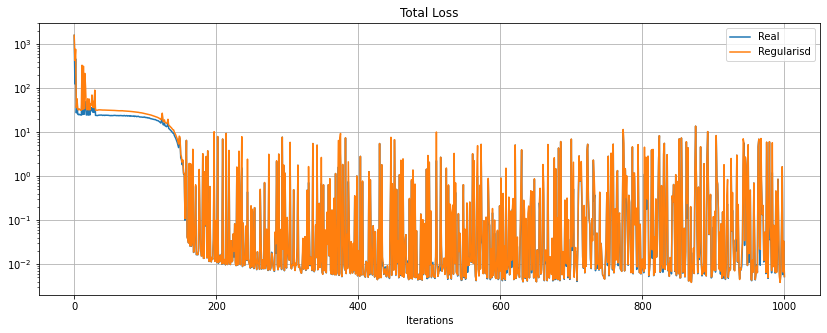

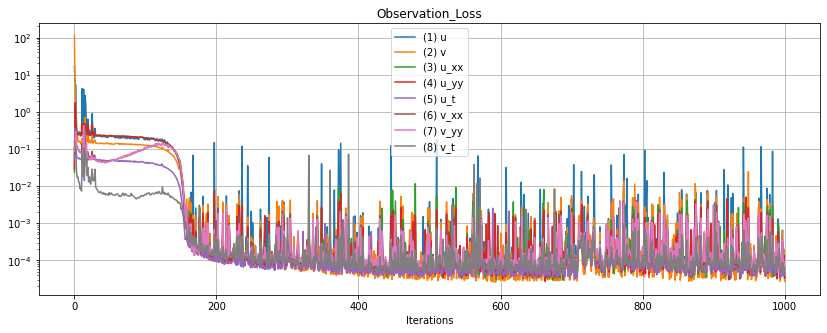

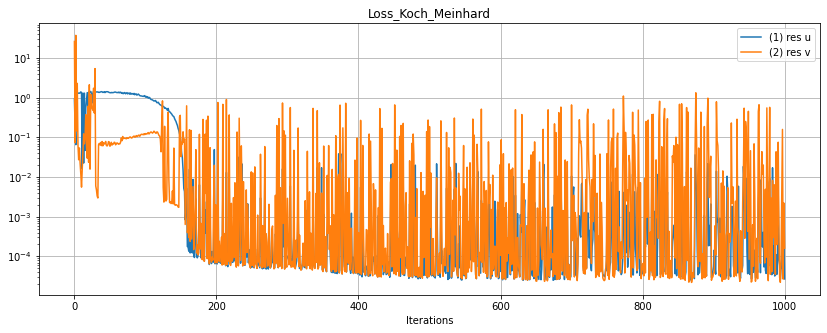

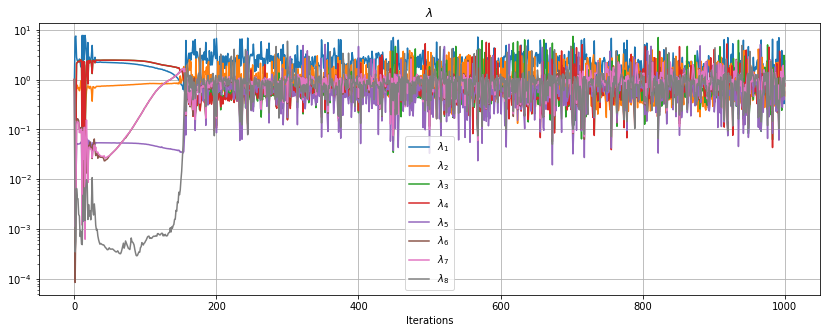

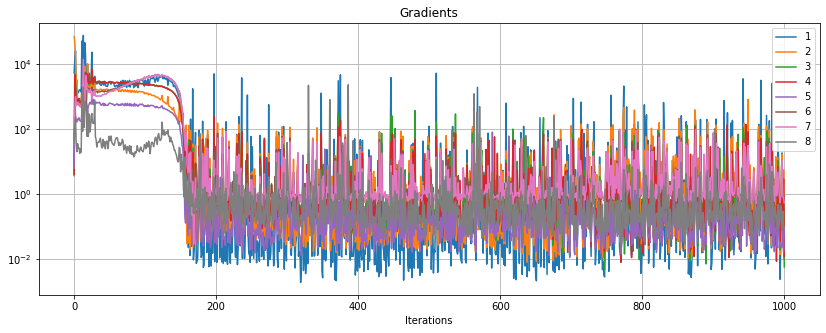

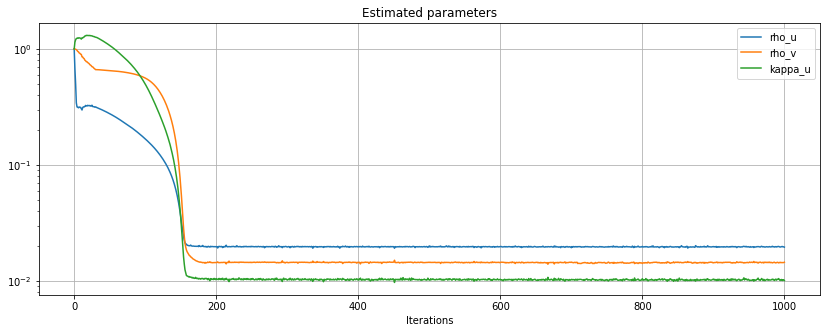

In [31]:
plot_result(merge_dict(results_KM, results_KM2), 
           modelKM, start=0,skip=100, param_names=pde_resKM.parameter_names())

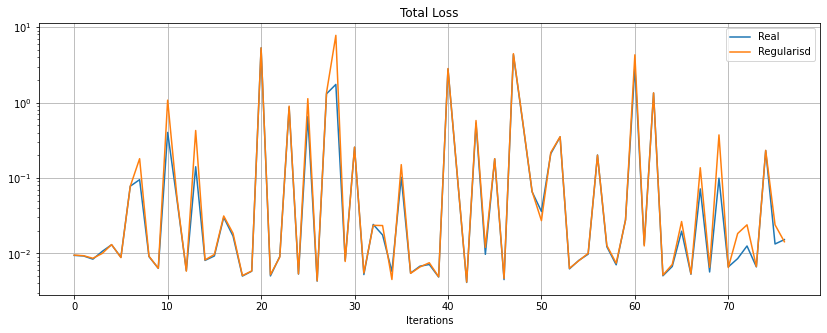

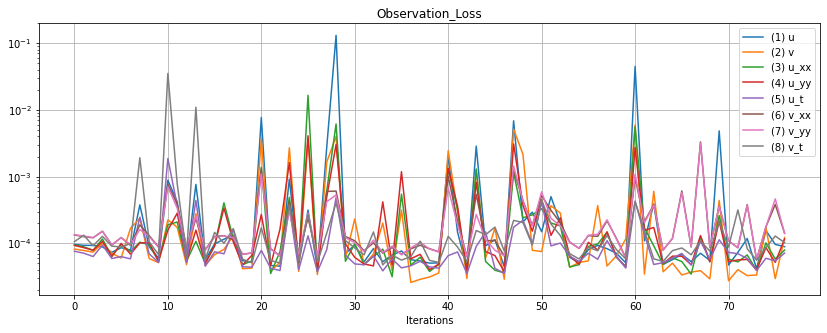

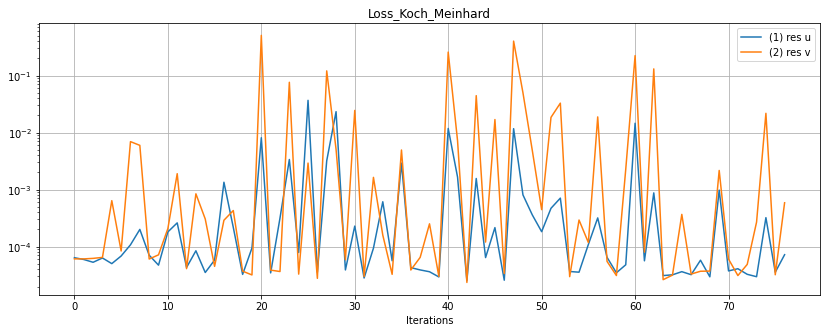

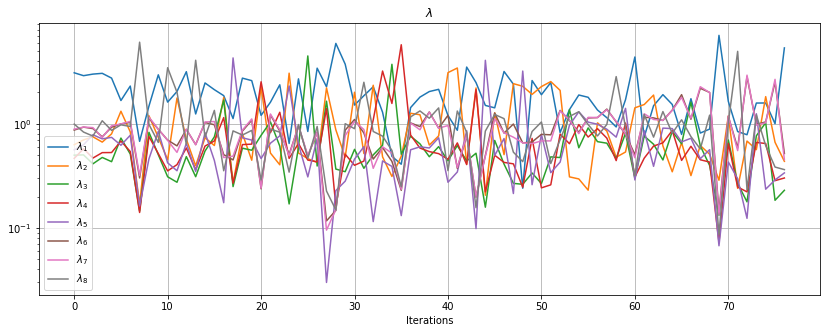

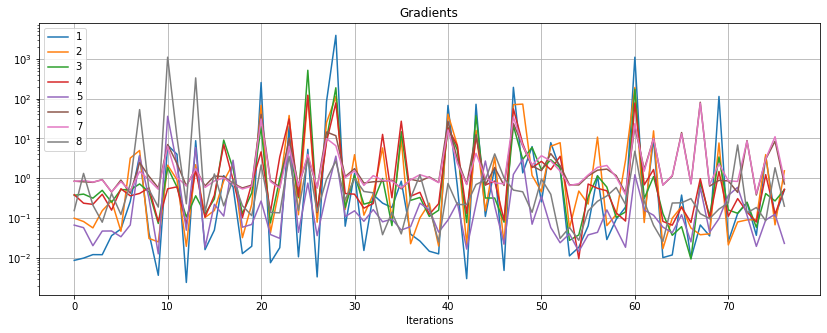

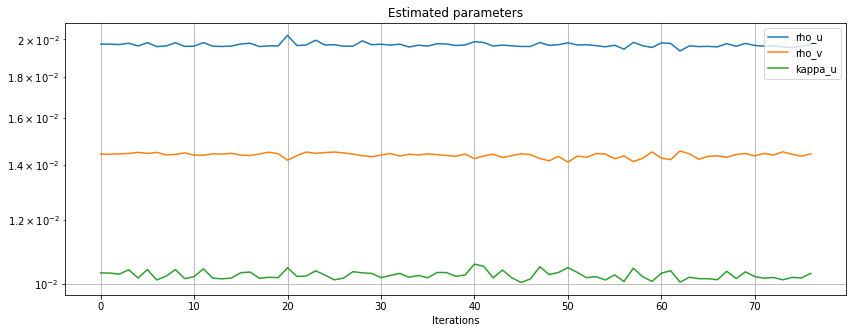

In [34]:
plot_result(merge_dict(results_KM2), 
           modelKM, start=20000, skip=1000, param_names=pde_resKM.parameter_names())

In [90]:
#modelKM.save(".", "patch_points_parameter_estimation_derivatives_outputs")


In [24]:
modelKM = tu.TINN.restore(".", "patch_points_parameter_estimation_derivatives_outputs_100000", ds_obs)
pinnKM = modelKM.pinn
obs_loss = modelKM.losses[0]
pde_resKM = modelKM.losses[1]

2022-12-19 20:46:19.243793: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-12-19 20:46:19.748658: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10


In [56]:
def norm_params2(result, simulation):
    #D_u = pde_resKM.D_u.get_value(test_d)
    #D_v = pde_resKM.D_v.get_value(test_d)
    D = simulation.Ds[1]/simulation.Ds[0]
    kappa_u = simulation.parameters["kappa_u"]*(simulation.parameters["sigma_u"]/simulation.parameters["mu_u"])**2
    rho_u = simulation.parameters["rho_u"]*(simulation.parameters["sigma_u"]*simulation.parameters["sigma_v"]/simulation.parameters["mu_u"]**3)
    rho_v = simulation.parameters["rho_v"]*(simulation.parameters["sigma_u"]**2/simulation.parameters["mu_u"]**3)
    
    D_2 = D
    rho_u2 = rho_u
    rho_v2 =rho_v
    kappa_u2 = kappa_u

    D = result["D"] if "D" in result.keys() else D
    rho_u = result["rho_u"] if "rho_u" in result.keys() else rho_u
    rho_v = result["rho_v"] if "rho_v" in result.keys() else rho_v
    kappa_u = result["kappa_u"] if "kappa_u" in result.keys() else kappa_u
    
    
    
    return ((D-D_2)**2 +
            (rho_u-rho_u2)**2 + 
            (rho_v-rho_v2)**2 +
            (kappa_u-kappa_u2)**2
           )

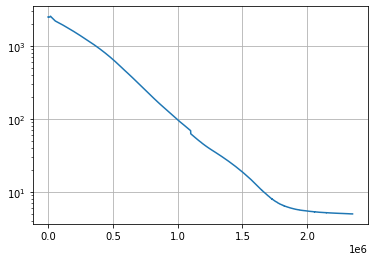

In [348]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2, results_KM3,
                                 results_KM4, results_KM5, results_KM6
                                , results_KM7, results_KM8, results_KM9), 
             simulation))
plt.yscale('log')
plt.grid()
plt.show()

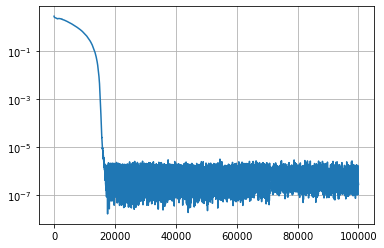

In [36]:
plt.plot(norm_params2(merge_dict(results_KM, results_KM2), 
             simulation))
plt.yscale('log')
plt.grid()
plt.show()

In [58]:
test_d = obs_X[:,:3].astype(np.float32)

In [349]:
r = pde_resKM.residual(pinnKM, test_d)
l2 = L2()

print([np.mean(i.numpy()**2) for i in r ])
print(l2.reduce_norm(r).numpy())
print(np.sqrt(l2.reduce_norm(r).numpy()))

[4.224154e-09, 9.242718e-09]
[4.224154e-09 9.242718e-09]
[6.4993488e-05 9.6139054e-05]


In [350]:
outputs =  pinnKM.net(test_d)
#u_xx = outputs[:,0]
#u,  u_xx = (outputs[:,0], outputs[:,1])
#u, v, u_xx = (outputs[:,0], outputs[:,1], outputs[:,2])
#u, v, u_xx, v_xx = (outputs[:,0], outputs[:,1], outputs[:,2], outputs[:,3])
u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (outputs[:,0], outputs[:,1], outputs[:,2],
                                         outputs[:,3], outputs[:,4], outputs[:,5],
                                         outputs[:,6], outputs[:,7])

u1 = u.numpy()[:block_size].reshape(block_x, block_y).T
u2 = u.numpy()[block_size:].reshape(block_x, block_y).T

v1 = v.numpy()[:block_size].reshape(block_x, block_y).T
v2 = v.numpy()[block_size:].reshape(block_x, block_y).T

u_xx1 = u_xx.numpy()[:block_size].reshape(block_x, block_y).T
u_xx2 = u_xx.numpy()[block_size:].reshape(block_x, block_y).T

v_xx1 = v_xx.numpy()[:block_size].reshape(block_x, block_y).T
v_xx2 = v_xx.numpy()[block_size:].reshape(block_x, block_y).T


u_yy1 = u_yy.numpy()[:block_size].reshape(block_x, block_y).T
u_yy2 = u_yy.numpy()[block_size:].reshape(block_x, block_y).T

v_yy1 = v_yy.numpy()[:block_size].reshape(block_x, block_y).T
v_yy2 = v_yy.numpy()[block_size:].reshape(block_x, block_y).T

u_t1 = u_t.numpy()[:block_size].reshape(block_x, block_y).T
u_t2 = u_t.numpy()[block_size:].reshape(block_x, block_y).T

v_t1 = v_t.numpy()[:block_size].reshape(block_x, block_y).T
v_t2 = v_t.numpy()[block_size:].reshape(block_x, block_y).T

In [351]:
der_u_outputs.shape

(32, 3)

In [352]:
print(np.sqrt(np.mean((u_xx1-der_u_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_yy1-der_u_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((u_t1-der_u_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_xx1-der_v_outputs[:block_size,0].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_yy1-der_v_outputs[:block_size,1].reshape(block_x, block_y).T)**2)))
print(np.sqrt(np.mean((v_t1-der_v_outputs[:block_size,2].reshape(block_x, block_y).T)**2)))

0.00012053899913546966
6.54892036643067e-05
9.920722191432604e-05
0.0008970920952428937
0.0009124801718539975
9.601660862548872e-05


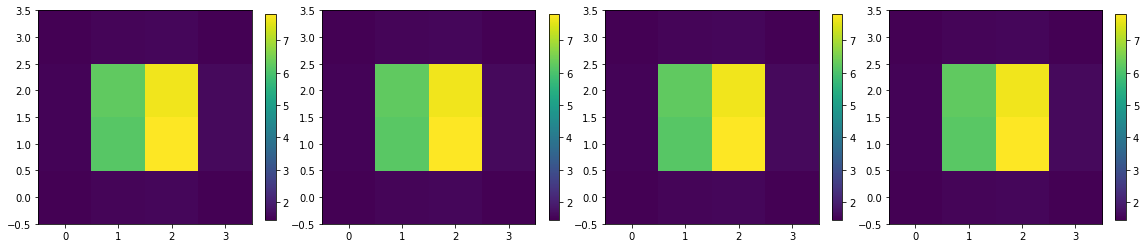

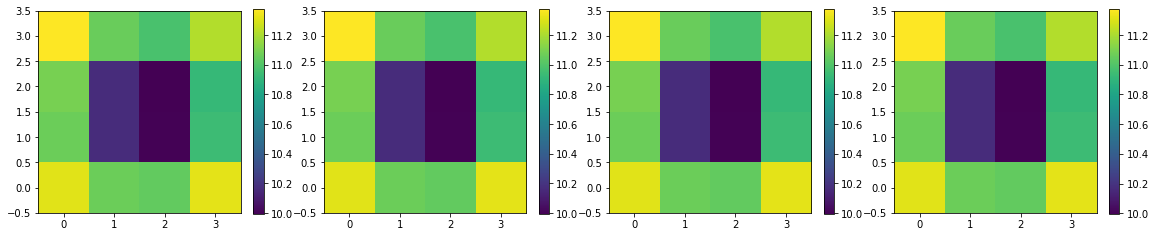

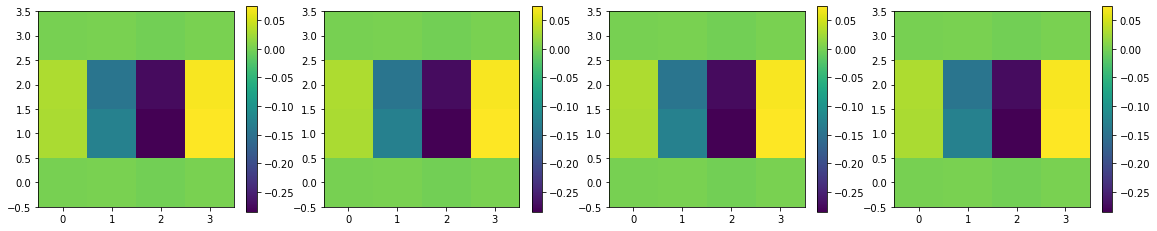

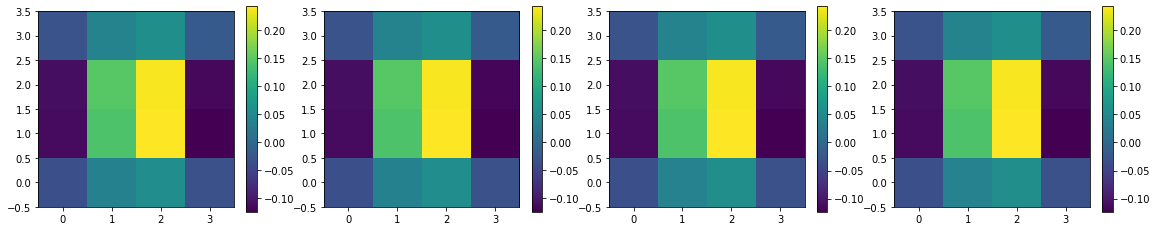

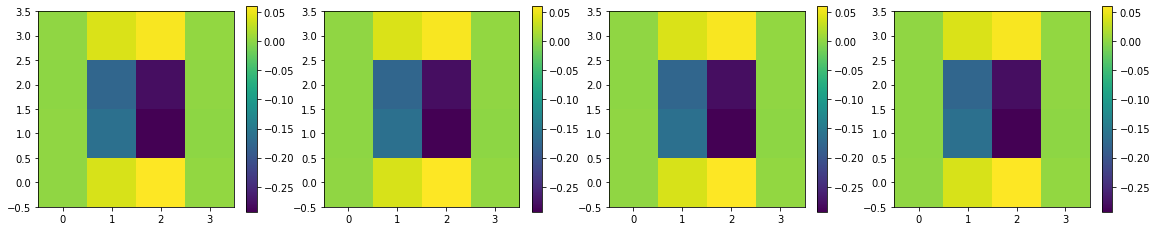

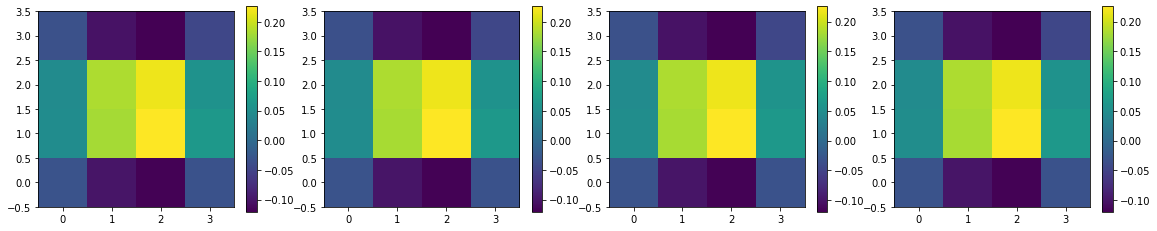

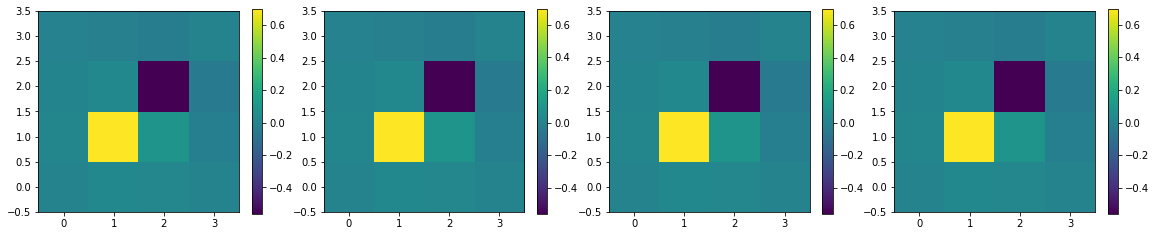

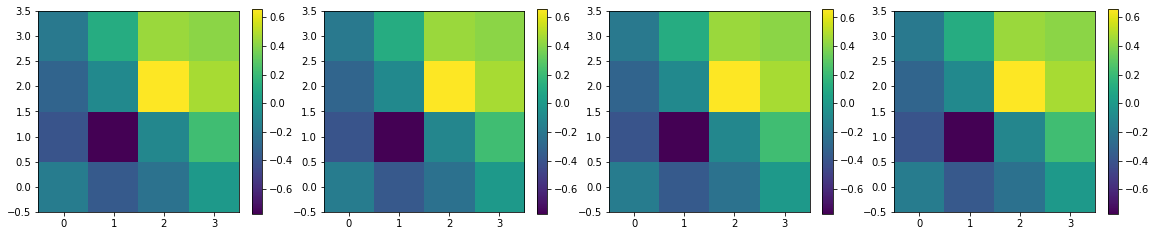

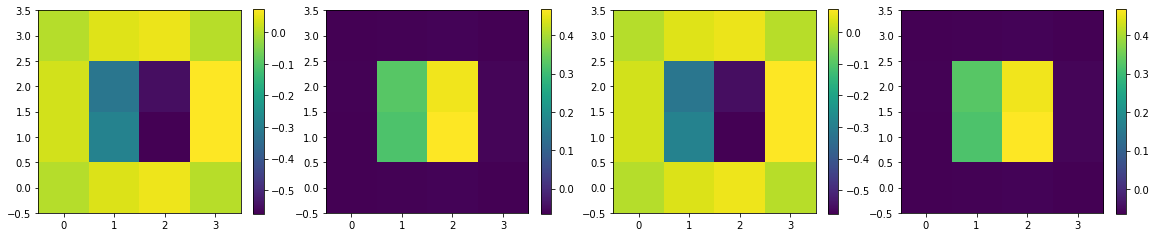

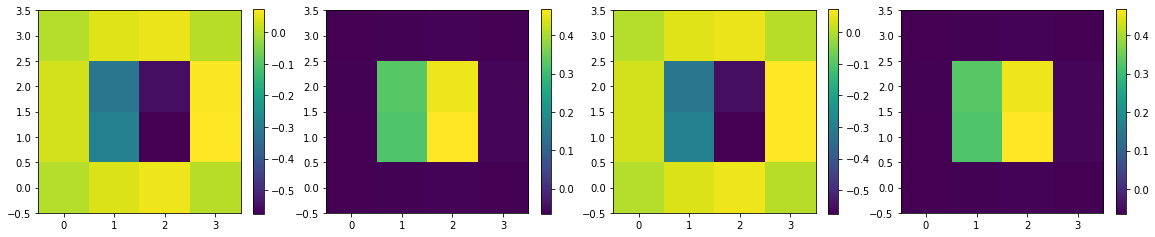

In [353]:
def p(m1, m2,  m3, m4):
    _ = plt.figure(figsize=(16,6))
    plt.subplot(141)
    plt.imshow(m1,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(142)
    plt.imshow(m2,
               origin='lower')
    plt.colorbar(shrink=.5)

    plt.subplot(143)
    plt.imshow(m3.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.subplot(144)
    plt.imshow(m4.reshape(block_x, block_y).T,
               origin='lower')
    plt.colorbar(shrink=.5)
    plt.tight_layout()
    plt.show()
p(u1, u2, obs_outputs[:block_size,0], obs_outputs[block_size:,0])
p(v1, v2, obs_outputs[:block_size,1], obs_outputs[block_size:,1])
p(u_xx1, u_xx2, der_u_outputs[:block_size,0], der_u_outputs[block_size:,0])
p(v_xx1, v_xx2, der_v_outputs[:block_size,0], der_v_outputs[block_size:,0])
p(u_yy1, u_yy2, der_u_outputs[:block_size,1], der_u_outputs[block_size:,1])
p(v_yy1, v_yy2, der_v_outputs[:block_size,1], der_v_outputs[block_size:,1])
p(u_t1, u_t2, der_u_outputs[:block_size,2], der_u_outputs[block_size:,2])
p(v_t1, v_t2, der_v_outputs[:block_size,2], der_v_outputs[block_size:,2])

p(u_xx1+u_yy1, (v_xx1+v_yy1), dataset['diff_output'][:block_size,0], dataset['diff_output'][:block_size,1])
p(u_xx2+u_yy2, (v_xx2+v_yy2), dataset['diff_output'][block_size:,0], dataset['diff_output'][block_size:,1])

In [337]:
from scipy.optimize import lsq_linear
from scipy import linalg

In [338]:
params = np.array([rho_u, D, rho_v])

In [354]:
params2 = np.array([pde_resKM.rho_u.get_value(0).numpy()[0], 
                    pde_resKM.D.get_value(0).numpy()[0], 
                    pde_resKM.rho_v.get_value(0).numpy()[0]])

In [355]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size

u_sol = u.numpy().flatten()
v_sol = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)


uxxyy_sol = (u_xx.numpy() + u_yy.numpy()).flatten()
vxxyy_sol = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_sol = np.vstack((np.c_[f_sol,  [0]*n2,  [0]*n2],
                   np.c_[[0]*n2,  vxxyy_sol, -f_sol]))


u_dt_sol = (u_t.numpy()/100).flatten()
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = np.r_[(uxxyy_sol-u_dt_sol-u_sol+1, -v_dt_sol+1)]
#b_sol = np.r_[(uxxyy_sol, vxxyy_sol)]

In [356]:
np.sqrt(np.mean(((np.dot(A_sol, params)+b_sol))**2))

0.012888034596179841

In [357]:
np.sqrt(np.mean(((np.dot(A_sol, params2)+b_sol))**2))

8.206002896477086e-05

In [358]:
params3 = linalg.solve(np.dot(A_sol.T,A_sol), -np.dot(A_sol.T,b_sol))
params3

array([1.95058623e-02, 9.77675650e+01, 1.47502555e-02])

In [359]:
np.sqrt(np.mean(((np.dot(A_sol, params3)+b_sol))**2))

4.9839658476115134e-05

In [360]:
params2

array([1.9505853e-02, 9.7756248e+01, 1.4748963e-02], dtype=float32)

In [279]:
kappa_u

0.010000000000000002

In [82]:
np.max(u_actual)-np.min(u_actual)

6.341826562258701

In [208]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [248]:
np.sqrt(0.00097)/np.sqrt(np.max(der_v_outputs[:test_size, 0]**2 ))

0.12872605200828996

In [249]:
np.sqrt(0.00097)/np.sqrt(np.mean(der_v_outputs[:test_size, 0]**2 ))

0.2637518238175379

In [241]:
np.max(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) - np.min(der_v_outputs[:test_size, 0]+der_v_outputs[:test_size, 1]) 

0.5324497151440455

In [282]:
test_size = 32
u_actual = u.numpy().flatten()
v_actual = v.numpy().flatten()

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (u_xx.numpy() + u_yy.numpy()).flatten()

#(v_xx.numpy() + v_yy.numpy()).flatten()/10
vxxyy_actual = (der_v_outputs[:test_size, 0] + #np.random.normal(0, .05, test_size)+
                der_v_outputs[:test_size, 1]).flatten()/10
vxxyy_actual = (v_xx.numpy() + v_yy.numpy()).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (u_t.numpy()/100).flatten()
v_dt_actual = (v_t.numpy()/1000).flatten()

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [283]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.96889015e-02, 6.07703016e+01, 1.06397409e-02])

In [172]:
test_size = 32
u_actual = obs_outputs[:test_size, 0]
v_actual = obs_outputs[:test_size, 1]

kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])
vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                      np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


u_dt_actual = (der_u_outputs[:test_size, 2] /100)
v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]

In [173]:
params4 = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
params4

array([1.97328100e-02, 9.94934181e+01, 1.51207473e-02])

In [284]:
def add_noise(noise_level = 0, kappa_sol = None):
    test_size = 33
    u_actual = obs_outputs[:test_size, 0].copy() 
    v_actual = obs_outputs[:test_size, 1].copy()    
    test_size = len(u_actual)
    
    if kappa_sol is None:
        kappa_sol = pde_resKM.kappa_u.get_value(0).numpy()[0]

    f_actual = u_actual * u_actual * v_actual / (1.0 + kappa_sol * u_actual * u_actual)


    uxxyy_actual = (der_u_outputs[:test_size, 0] + der_u_outputs[:test_size, 1])    
    
    
    if noise_level > 0:
        v_xx_band = np.max(der_v_outputs[:test_size, 0])-np.min(der_v_outputs[:test_size, 0])
        v_yy_band = np.max(der_v_outputs[:test_size, 1])-np.min(der_v_outputs[:test_size, 1])
        vxx_actual = der_v_outputs[:test_size, 0] + np.random.normal(0, v_xx_band*noise_level , test_size)
        vyy_actual = der_v_outputs[:test_size, 1] + np.random.normal(0, v_yy_band*noise_level , test_size)
        vxxyy_actual =(vxx_actual + vyy_actual).flatten()/10        
    else:
        vxx_actual = der_v_outputs[:test_size, 0]
        vyy_actual = der_v_outputs[:test_size, 1]
        vxxyy_actual = (der_v_outputs[:test_size, 0] + der_v_outputs[:test_size, 1]).flatten()/10

    A_actual = np.vstack((np.c_[f_actual,  [0]*test_size,  [0]*test_size],
                          np.c_[[0]*test_size,  vxxyy_actual, -f_actual]))


    u_dt_actual = (der_u_outputs[:test_size, 2] /100)
    v_dt_actual = (der_v_outputs[:test_size, 2] /1000)

    b_actual = np.r_[(uxxyy_actual-u_dt_actual-u_actual+1, -v_dt_actual+1)]
    params_pred = linalg.solve(np.dot(A_actual.T,A_actual), -np.dot(A_actual.T,b_actual))
    
    v_xx_err = np.mean((der_v_outputs[:test_size, 0] - vxx_actual)**2)
    v_yy_err = np.mean((der_v_outputs[:test_size, 1] - vyy_actual)**2)    
    return tuple(params_pred.tolist() )+ (v_xx_err, v_yy_err)
    

In [201]:
print(np.mean((der_v_outputs[:test_size, 0] - v_xx.numpy())**2))
print(np.mean((der_v_outputs[:test_size, 1] - v_yy.numpy())**2))

0.0009904267918598244
0.000986807834585626


In [285]:
noise_levels = np.linspace(0,.3, 100)
ensumble_n = 100
for n in range(ensumble_n):
    if n == 0:
        estimates = np.array([add_noise(n_l) for n_l in noise_levels])
    else:
        estimates += np.array([add_noise(n_l) for n_l in noise_levels])
        
estimates /= ensumble_n

In [286]:
estimates.shape

(100, 5)

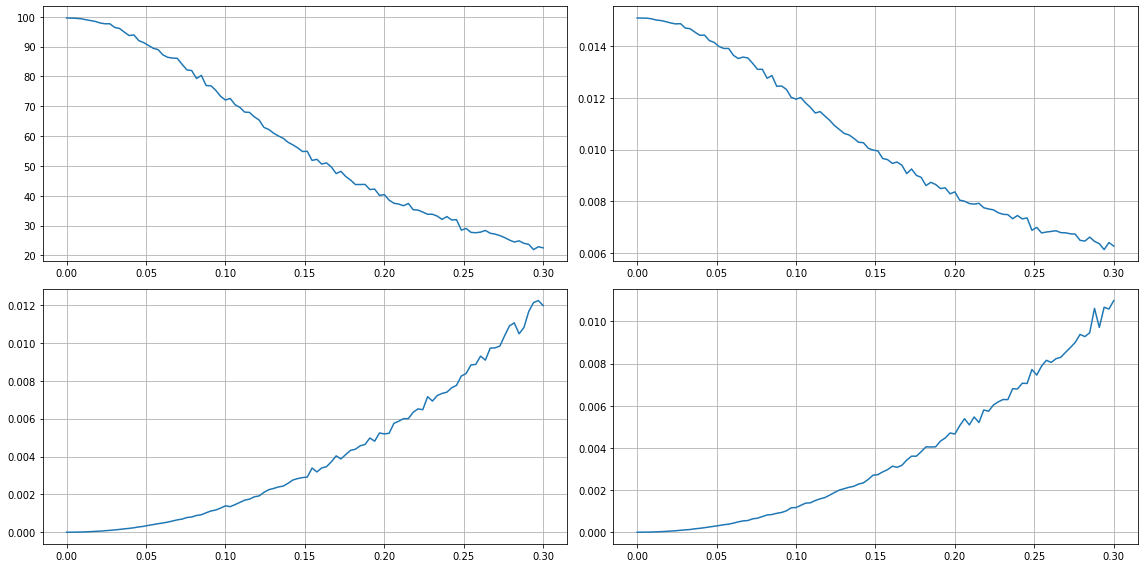

In [287]:
_ = plt.figure(figsize=(16, 8))
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,i*2+j+1)
        plt.plot(noise_levels, estimates[:, i*2+j+1])        
        plt.grid()
plt.tight_layout()
plt.show()

In [138]:
add_noise(0)

(0.01973280997722836,
 99.49341812882234,
 0.015120747280319324,
 0.0,
 0.0,
 3.7494859510203646e-06,
 8.287541347416645e-07)

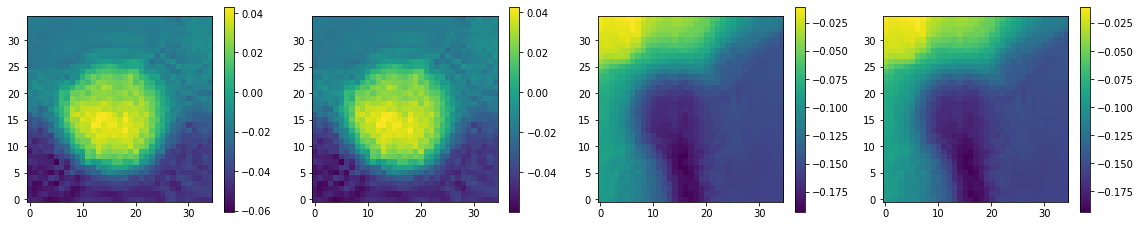

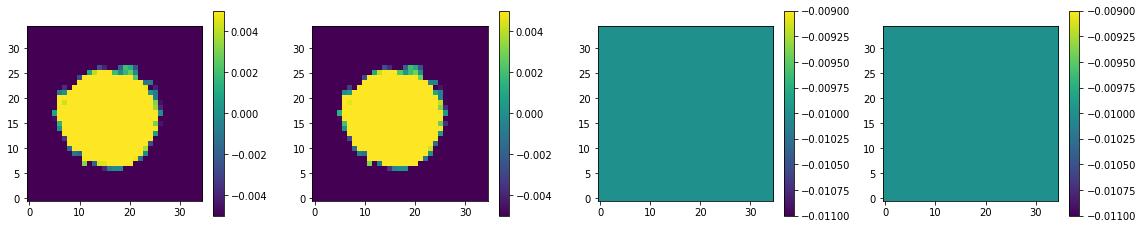

In [56]:
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1,res2,res3,res4)
thres1=0.005
thres2=-0.005
res1[res1 > thres1] = thres1
res1[res1 < thres2] = thres2
res2[res2 > thres1] = thres1
res2[res2 < thres2] = thres2
thres1=0.01
thres2=-0.01
res3[res3 > thres1] = thres1
res3[res3 < thres2] = thres2
res4[res4 > thres1] = thres1
res4[res4 < thres2] = thres2
p(res1,res2,res3,res4)

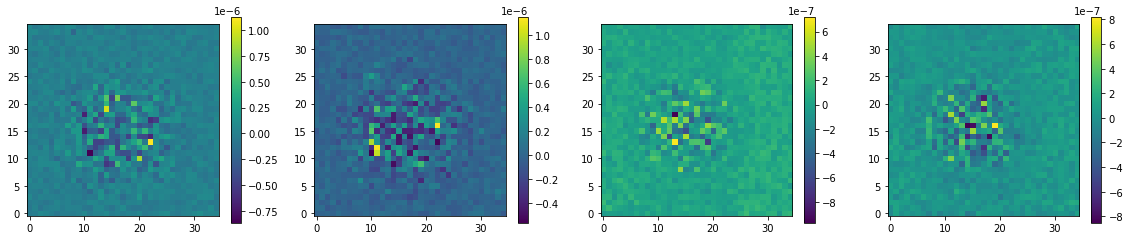

In [57]:
fu_sol, fv_sol = pde_resKM.residual(pinnKM, test_d)
res1=(np.dot(A_sol, params2)+b_sol
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_sol, params2)+b_sol
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_sol, params2)+b_sol
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_sol, params2)+b_sol
     )[3*block_size:].reshape(block_x, block_y).T
p(res1+fu_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res2+fu_sol.numpy()[block_size:].reshape(block_x, block_y).T,
  res3+fv_sol.numpy()[:block_size].reshape(block_x, block_y).T,
  res4+fv_sol.numpy()[block_size:].reshape(block_x, block_y).T,)

In [61]:
res_obs = lsq_linear(A_sol, b_sol, bounds=(0.0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1, -1, -1])
        cost: 16551.379752990466
         fun: array([ 0.55743337,  0.55322146,  0.55879426, ..., -0.99963897,
       -0.99963588, -0.99964142])
     message: 'The first-order optimality measure is less than `tol`.'
         nit: 13
  optimality: 4.320909614557874e-28
      status: 1
     success: True
           x: array([1.27266364e-46, 2.09048140e-28, 8.46731860e-48])

In [269]:
n =  simulation.n[0]*simulation.n[1]
l = simulation.L[0]*simulation.L[1]
n2 = 2*block_size
u_obs = obs_outputs[:,0].flatten()
v_obs = obs_outputs[:,1].flatten()
f_obs = u_obs * u_obs * v_obs / (1.0 + simulation.parameters['kappa_u'] * u_obs * u_obs)
A_obs = np.vstack((np.c_[f_obs, -u_obs, [1]*n2, [0]*n2, [0]*n2],
                   np.c_[[0]*n2, [0]*n2, [0]*n2, -f_obs, [1]*n2]))

uxxyy_obs =simulation.Ds[0] *  (der_u_outputs[:,0] + der_u_outputs[:,1]).flatten()
vxxyy_obs =simulation.Ds[1] *  (der_v_outputs[:,0] + der_v_outputs[:,1]).flatten()
u_dt = der_u_outputs[:,2].flatten()
v_dt = der_v_outputs[:,2].flatten()

b_obs = np.r_[(uxxyy_obs-u_dt, vxxyy_obs-v_dt)]

In [169]:
np.sqrt(np.mean(((np.dot(A_obs, params)+b_obs))**2))

4.3139633449820096e-07

In [303]:
res_obs = lsq_linear(A_obs, b_obs, bounds=(0, np.inf), tol=1e-16)
res_obs

 active_mask: array([-1,  0,  0, -1,  0])
        cost: 55.98322605362867
         fun: array([0.01198398, 0.01190489, 0.01179273, ..., 0.13051092, 0.13049243,
       0.1304939 ])
     message: 'The relative change of the cost function is less than `tol`.'
         nit: 9
  optimality: 1.7763568394002505e-14
      status: 2
     success: True
           x: array([2.11852294e-033, 7.28018337e-002, 2.27743983e-002, 4.94065646e-324,
       6.59956339e-002])

In [136]:
b_obs = np.r_[(uxxyy_obs, vxxyy_obs)]

In [160]:
res1=(np.dot(A_obs, params2)+b_obs
     )[:block_size].reshape(block_x, block_y).T
res2=(np.dot(A_obs, params2)+b_obs
     )[block_size:2*block_size].reshape(block_x, block_y).T
res3=(np.dot(A_obs, params2)+b_obs
     )[2*block_size:3*block_size].reshape(block_x, block_y).T
res4=(np.dot(A_obs, params2)+b_obs
     )[3*block_size:].reshape(block_x, block_y).T

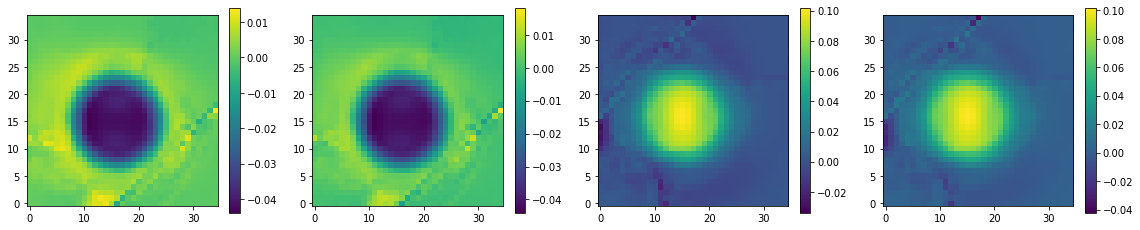

In [161]:
p(res1,res2,res3,res4)

In [380]:
import rdsolver

In [403]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 2*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = pde_resKM.sigma_u.get_value(0).numpy()[0]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = pde_resKM.sigma_v.get_value(0).numpy()[0]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -pde_resKM.mu_u.get_value(0).numpy()[0]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (pde_resKM.rho_u.get_value(0).numpy()[0],
          pde_resKM.rho_v.get_value(0).numpy()[0],
          pde_resKM.kappa_u.get_value(0).numpy()[0])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [01:26<00:00,  8.61s/it]


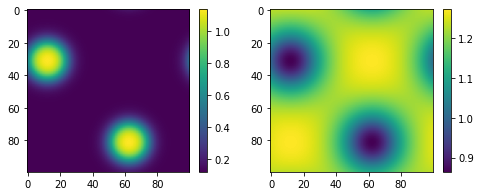

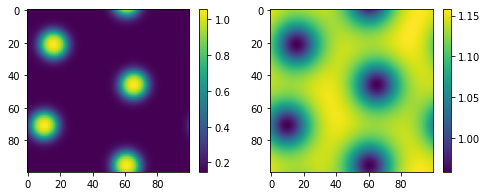

In [406]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [388]:
simulation

Simulation(name='Koch_Meinhardt_9', n=(100, 100), L=(8, 8), Ds=(0.01, 1.0), dt=0.001, t_start=0, t_end=768.0, t_steps=769, dt_arr=None, parameters={'kappa_u': 1.0, 'mu_u': 1.0, 'rho_u': 1.95, 'rho_v': 1.5, 'sigma_u': 0.1, 'sigma_v': 0.1}, steady_state_func=None, perturbation_size=0.1, kinetic_func=None, tol=0.001, sample_parameters=True, sample_parameters_num=10, sample_parameters_std=(0.0, 0.01, 0.01, 0.01, 0.001, 0.001), same_init=True, c0=None)

In [421]:
# Load a standard ASDM model
D, beta, gamma, f, f_args, homo_ss = rdsolver.models.asdm()

# Set up the space and time grid
n = simulation.n#(32, 32)
L = simulation.L#(50, 50)
t = np.linspace(0, 4*768, 10)#t_star#np.linspace(0, 100000, 256)

# Include the estimated params
D_a = simulation.Ds[0]#pde_lossKM..numpy()#0.01558*const1#0.005
D_s = simulation.Ds[1]#pde_lossKM.D_s.numpy()#0.03886*const2#0.2
D[0] = D_a # D_a
D[1] = D_s # D_s
beta[0] = 4*simulation.parameters["sigma_u"]#pde_lossKM.sigma_a.numpy()#0.00040#0.00097*const1# sigma_a
beta[1] = simulation.parameters["sigma_v"]#pde_lossKM.sigma_s.numpy()#0.01521#0.00345*const2 # sigma_s
gamma[0,0] = -4*simulation.parameters["mu_u"]#-pde_lossKM.mu_a.numpy()#-0.01046#-0.03316*const1#mu_a
# rho_a,  rho_s, kappa_a
f_args = (4*simulation.parameters["rho_u"],
          simulation.parameters["rho_v"],
          simulation.parameters["kappa_u"])
#(pde_lossKM.rho_a.numpy(), pde_lossKM.rho_s.numpy(), pde_lossKM.kappa_a.numpy())


# Initial condition and solve
#c0 = rdsolver.initial_condition(uniform_conc=homo_ss, n=n, L=L)
#c0 = data[:, :, :, 0]
data_path = os.path.abspath("../../test/outputs_Koch_Meinhardt_100_by_100/Koch_Meinhardt_9/Koch_Meinhardt_9.npy")
with open(data_path, 'rb') as f1:
    aux_data = np.load(f1)
c0 = aux_data[:, :, :, 1]
c = rdsolver.solve(c0, t, D=D, beta=beta, gamma=gamma, f=f, f_args=f_args, L=L)


100%|██████████| 10/10 [02:05<00:00, 12.55s/it]


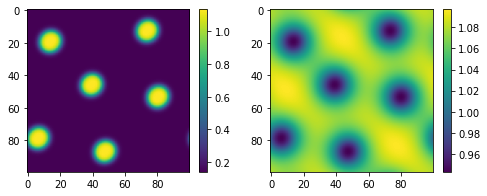

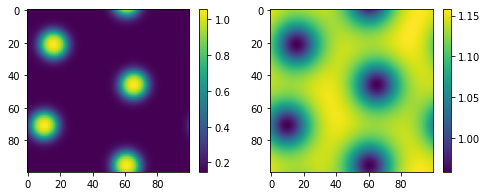

In [422]:
_ = plt.figure(figsize=(8,4))
plt.title("Solution by estimates")
plt.subplot(121)
plt.imshow(c[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(c[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()
_ = plt.figure(figsize=(8,4))
plt.title("Solution")
plt.subplot(121)
plt.imshow(aux_data[0, :,:,-1])
plt.colorbar(shrink=.75)
plt.subplot(122)
plt.imshow(aux_data[1, :,:,-1])
plt.colorbar(shrink=.75)
plt.show()

In [407]:
print(pde_resKM.trainables_str())

sigma_u: 0.03358 sigma_v: 0.08917 mu_u: 0.38960 rho_u: 0.74692 
rho_v: 1.29434 kappa_u: 0.75477 


In [408]:
simulation.parameters

{'kappa_u': 1.0,
 'mu_u': 1.0,
 'rho_u': 1.95,
 'rho_v': 1.5,
 'sigma_u': 0.1,
 'sigma_v': 0.1}

In [412]:
(1/0.38960)#*0.03358

2.566735112936345

In [414]:
2.5*0.74692 

1.8673000000000002

In [268]:
minimize_parameters(pde_resKM, pinnKM, test_d, [pde_resKM.rho_u, pde_resKM.rho_v, pde_resKM.kappa_u], 
                    method="Nelder-Mead", tol=1e-9 )

 final_simplex: (array([[0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ],
       [0.02013884, 0.06914701, 0.0114    ]]), array([4.10391617, 4.10391617, 4.10391617, 4.10391617]))
           fun: 4.103916168212891
       message: 'Optimization terminated successfully.'
          nfev: 231
           nit: 119
        status: 0
       success: True
             x: array([0.02013884, 0.06914701, 0.0114    ])

In [62]:
import copy

In [81]:

pde_resKM2 = copy.deepcopy(pde_resKM) 

In [82]:

@tf.function
def resi4(v1, v2):
    pde_resKM2.D.set_value(v1)
    pde_resKM2.rho_v.set_value(v2)
    return pde_resKM2.residual(pinnKM, test_d)   

In [156]:
D_range = np.linspace(40, 80, 30)
rho_v_range = np.linspace(.01, .012, 30)

D_mesh, rho_v_mesh = np.meshgrid(D_range, rho_v_range)

In [157]:
v_res = np.zeros_like(rho_v_mesh)
l2_norm = L2()
for i, _ in enumerate(D_mesh):    
    
    for j, _ in enumerate(rho_v_mesh):
        v1 = D_mesh[i,j]
        v2 = rho_v_mesh[i,j]        
        
        test_pde_u, test_pde_v = resi4(v1.astype(np.float32), v2.astype(np.float32))        
        
        v_res[i,j] = l2_norm.reduce_norm((test_pde_v,)).numpy()[0]
        

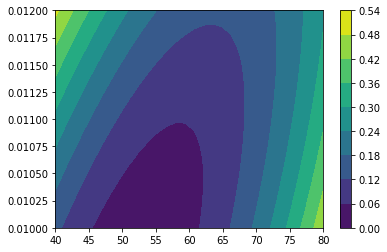

In [159]:
#_ = plt.figure(figsize=(16,4))

plt.contourf(D_range, rho_v_range, v_res)
#plt.imshow(v_res)
plt.colorbar()

plt.show()


In [160]:
print(pde_resKM.trainables_str())

D: 52.67937 rho_u: 0.02041 rho_v: 0.00995 kappa_u: 0.01109 



In [161]:
pde_resKM.outputs_correction_fact

ListWrapper([<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=0.01>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.1>, <tf.Tensor: shape=(), dtype=float32, numpy=0.001>])

In [167]:
@tf.function
def resi2():
    outputs = pinnKM.net(test_d)
    u, v, u_xx, u_yy, u_t, v_xx, v_yy, v_t = (
        outputs[:, 0] * pde_resKM.outputs_correction_fact[0],
        outputs[:, 1] * pde_resKM.outputs_correction_fact[1],
        outputs[:, 2] * pde_resKM.outputs_correction_fact[2],
        outputs[:, 3] * pde_resKM.outputs_correction_fact[3],
        outputs[:, 4] * pde_resKM.outputs_correction_fact[4],
        outputs[:, 5] * pde_resKM.outputs_correction_fact[5],
        outputs[:, 6] * pde_resKM.outputs_correction_fact[6],
        outputs[:, 7] * pde_resKM.outputs_correction_fact[7],
    )
    D = pde_resKM.D.get_value(0)        
    rho_v = pde_resKM.rho_v.get_value(0)
    kappa_u = pde_resKM.kappa_u.get_value(0)
    f = u * u * v / (1.0 + kappa_u * u * u)
    return (v_t - 1, v_xx + v_yy, f)

In [168]:
kappa_u

0.010000000000000002

In [169]:

#pde_resKM.kappa_u.set_value(0.01136 )
pde_resKM.kappa_u.set_value(kappa_u)
a, d, b = resi2()

In [165]:

f_sol = u_sol * u_sol * v_sol / (1.0 + kappa_sol * u_sol * u_sol)
A_sol =  f_sol

vxxyy_sol = D * (v_xx.numpy() + v_yy.numpy()).flatten()/10
v_dt_sol = (v_t.numpy()/1000).flatten()

b_sol = v_dt_sol-vxxyy_sol-1

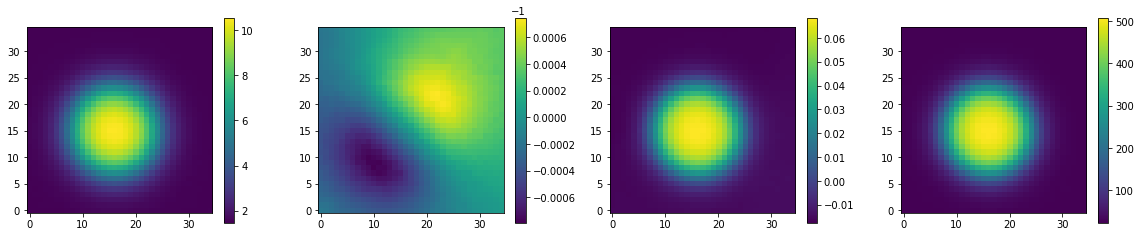

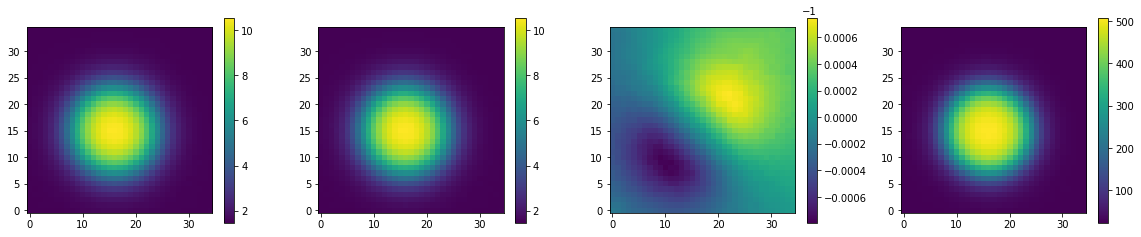

In [171]:
p(u1,  a.numpy()[:block_size].reshape(block_x, block_y).T,d.numpy()[:block_size], b.numpy()[:block_size])
p(u1, u2, a.numpy()[block_size:], b.numpy()[block_size:])
#p(u1, u2, a.numpy()[:block_size]/b.numpy()[:block_size], a.numpy()[block_size:]/b.numpy()[block_size:])
#p(u1, u2, b_sol[block_size:], A_sol[block_size:] )

In [102]:
A_sol[2*block_size:, 1].shape

(2450,)

In [104]:
b_sol[2*block_size:].shape

(2450,)